Toxicity Dataset : https://archive.ics.uci.edu/dataset/728/toxicity-2

The dataset includes 171 molecules designed for functional domains of a core clock protein, CRY1, responsible for generating circadian rhythm. 56 of the molecules are toxic and the rest are non-toxic. 

The data consists a complete set of 1203 molecular descriptors and needs feature selection before classification since some of the features are redundant. 

Introductory Paper:
Structure-based design and classifications of small molecules regulating the circadian rhythm period
By Seref Gul, F. Rahim, Safak Isin, Fatma Yilmaz, Nuri Ozturk, M. Turkay, I. Kavakli. 2021
https://www.semanticscholar.org/paper/Structure-based-design-and-classifications-of-small-Gul-Rahim/5944836c47bc7d1a2b0464a9a1db94d4bc7f28ce

# IMPORTS

In [11]:
pip install ucimlrepo

In [12]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

from ucimlrepo import fetch_ucirepo 

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    cross_validate, GridSearchCV, learning_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc, roc_curve,
    classification_report, matthews_corrcoef
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

# For SMOTE (install: pip install imbalanced-learn)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# For statistical testing
from scipy.stats import ttest_rel, wilcoxon

In [13]:
# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

In [14]:
# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# DATA LOAD AND PREPROCESSING

In [15]:
data = fetch_ucirepo(id=728)
X = data.data.features
y = data.data.targets

# Binary encoding: NonToxic=1, Toxic=0
y_binary = (y['Class'] == 'NonToxic').astype(int)

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Feature matrix shape: {X.shape}")
print(f"Number of molecules (n): {X.shape[0]}")
print(f"Number of descriptors (p): {X.shape[1]}")
print(f"Dimensionality ratio (p/n): {X.shape[1]/X.shape[0]:.2f}")
print(f"\nClass distribution:")
print(y['Class'].value_counts())
print(f"\nClass balance:")
for cls, count in y['Class'].value_counts().items():
    pct = count / len(y) * 100
    print(f"  {cls}: {count} ({pct:.2f}%)")

DATASET OVERVIEW
Feature matrix shape: (171, 1203)
Number of molecules (n): 171
Number of descriptors (p): 1203
Dimensionality ratio (p/n): 7.04

Class distribution:
Class
NonToxic    115
Toxic        56
Name: count, dtype: int64

Class balance:
  NonToxic: 115 (67.25%)
  Toxic: 56 (32.75%)


In [16]:
# Check for missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y_binary.isnull().sum()}")


Missing values in features: 0
Missing values in target: 0


# Feature Correlation Analysis


FEATURE CORRELATION ANALYSIS (threshold > 0.9)
Total feature pairs with correlation > 0.9: 3702

Top 10 highest correlations:
Feature1 Feature2  Correlation
 khs.tCH  maxHtCH          1.0
   nHtCH  maxHtCH          1.0
    ntCH  minHtCH          1.0
    ntCH  maxHtCH          1.0
   SHtCH    nHtCH          1.0
   SHtCH     ntCH          1.0
   SHtCH    C2SP1          1.0
   C2SP1  maxHtCH          1.0
   C2SP1  minHtCH          1.0
 minHtCH  khs.tCH          1.0


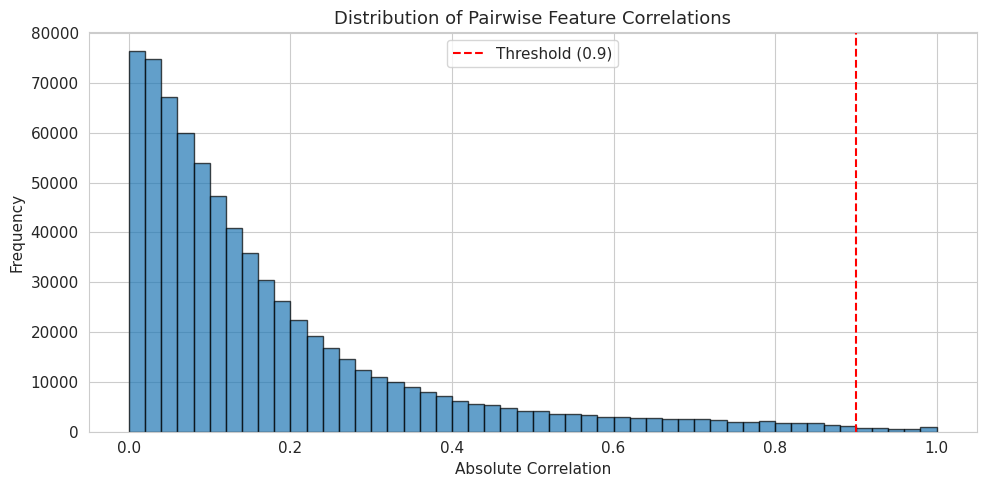


Percentage of feature pairs with |r| > 0.9: 0.51%


In [17]:
def analyze_feature_correlation(X, threshold=0.9):
    """Analyze pairwise feature correlations"""
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    high_corr_pairs = []
    for column in upper_tri.columns:
        high_corr_features = upper_tri.index[upper_tri[column] > threshold].tolist()
        for feat in high_corr_features:
            high_corr_pairs.append((column, feat, upper_tri.loc[feat, column]))
    
    print(f"\n{'='*80}")
    print(f"FEATURE CORRELATION ANALYSIS (threshold > {threshold})")
    print("="*80)
    print(f"Total feature pairs with correlation > {threshold}: {len(high_corr_pairs)}")
    
    if len(high_corr_pairs) > 0:
        corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature1', 'Feature2', 'Correlation'])
        corr_df = corr_df.sort_values('Correlation', ascending=False)
        print(f"\nTop 10 highest correlations:")
        print(corr_df.head(10).to_string(index=False))
        
        # Visualize correlation distribution
        all_corrs = upper_tri.values[np.triu_indices_from(upper_tri.values, k=1)]
        all_corrs = all_corrs[~np.isnan(all_corrs)]
        
        plt.figure(figsize=(10, 5))
        plt.hist(all_corrs, bins=50, edgecolor='black', alpha=0.7)
        plt.axvline(threshold, color='red', linestyle='--', 
                   label=f'Threshold ({threshold})')
        plt.xlabel('Absolute Correlation')
        plt.ylabel('Frequency')
        plt.title('Distribution of Pairwise Feature Correlations')
        plt.legend()
        plt.tight_layout()
        plt.savefig('feature_correlation_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        pct_high_corr = (len(high_corr_pairs) / (X.shape[1] * (X.shape[1]-1) / 2)) * 100
        print(f"\nPercentage of feature pairs with |r| > {threshold}: {pct_high_corr:.2f}%")
    
    return high_corr_pairs

high_corr_pairs = analyze_feature_correlation(X, threshold=0.9)


# Train-Test Split with Stratification

In [18]:
# Shuffle dataset
np.random.seed(RANDOM_STATE)
shuffle_idx = np.random.permutation(len(X))
X_shuffled = X.iloc[shuffle_idx].reset_index(drop=True)
y_shuffled = y_binary.iloc[shuffle_idx].reset_index(drop=True)

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2,
    random_state=RANDOM_STATE, stratify=y_shuffled
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n{'='*80}")
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"\nTraining class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest class distribution:")
print(pd.Series(y_test).value_counts())

feature_names = X.columns.tolist()


TRAIN-TEST SPLIT
Training set: (136, 1203)
Test set: (35, 1203)

Training class distribution:
Class
1    91
0    45
Name: count, dtype: int64

Test class distribution:
Class
1    24
0    11
Name: count, dtype: int64


# SMOTE for Class Imbalance

In [19]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\n{'='*80}")
print("SMOTE RESAMPLING")
print("="*80)
print(f"Original training size: {X_train_scaled.shape}")
print(f"SMOTE training size: {X_train_smote.shape}")
print(f"\nOriginal class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nSMOTE class distribution:")
print(pd.Series(y_train_smote).value_counts())


SMOTE RESAMPLING
Original training size: (136, 1203)
SMOTE training size: (182, 1203)

Original class distribution:
Class
1    91
0    45
Name: count, dtype: int64

SMOTE class distribution:
Class
0    91
1    91
Name: count, dtype: int64


# MODEL DEFINITIONS WITH HYPERPARAMETER OPTIMIZATION

In [20]:
# Compute class weights for weighted models
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n{'='*80}")
print("CLASS WEIGHTS")
print("="*80)
print(f"Class 0 (Toxic): {class_weight_dict[0]:.3f}")
print(f"Class 1 (NonToxic): {class_weight_dict[1]:.3f}")


CLASS WEIGHTS
Class 0 (Toxic): 1.511
Class 1 (NonToxic): 0.747


In [21]:
# Enhanced model dictionary with more systematic hyperparameter coverage
models = {
    # ===== PENALIZED REGRESSION MODELS =====
    # No penalty
    'LR_No_Penalty': LogisticRegression(penalty=None, max_iter=5000, 
                                        solver='lbfgs', random_state=RANDOM_STATE),
    
    # Ridge (L2) - Multiple C values
    'LR_Ridge_C0.01': LogisticRegression(penalty='l2', C=0.01, max_iter=5000,
                                         solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C0.1': LogisticRegression(penalty='l2', C=0.1, max_iter=5000,
                                        solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C1': LogisticRegression(penalty='l2', C=1.0, max_iter=5000,
                                      solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C10': LogisticRegression(penalty='l2', C=10.0, max_iter=5000,
                                       solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C100': LogisticRegression(penalty='l2', C=100.0, max_iter=5000,
                                        solver='lbfgs', random_state=RANDOM_STATE),
    
    # Lasso (L1) - Multiple C values
    'LR_Lasso_C0.01': LogisticRegression(penalty='l1', C=0.01, max_iter=5000,
                                         solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C0.1': LogisticRegression(penalty='l1', C=0.1, max_iter=5000,
                                        solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C1': LogisticRegression(penalty='l1', C=1.0, max_iter=5000,
                                      solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C10': LogisticRegression(penalty='l1', C=10.0, max_iter=5000,
                                       solver='saga', random_state=RANDOM_STATE),
    
    # Elastic Net - Multiple configurations
    'LR_ElasticNet_L1_0.3_C0.1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                     l1_ratio=0.3, C=0.1, max_iter=5000,
                                                     random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.5_C0.1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                     l1_ratio=0.5, C=0.1, max_iter=5000,
                                                     random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.5_C1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                   l1_ratio=0.5, C=1.0, max_iter=5000,
                                                   random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.7_C1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                   l1_ratio=0.7, C=1.0, max_iter=5000,
                                                   random_state=RANDOM_STATE),
    
    # Weighted versions of best regularized models
    'LR_Lasso_C0.1_Weighted': LogisticRegression(penalty='l1', C=0.1, max_iter=5000,
                                                 solver='saga', class_weight='balanced',
                                                 random_state=RANDOM_STATE),
    'LR_Ridge_C0.1_Weighted': LogisticRegression(penalty='l2', C=0.1, max_iter=5000,
                                                 solver='lbfgs', class_weight='balanced',
                                                 random_state=RANDOM_STATE),
    
    # Other linear classifiers
    'Ridge_Classifier': RidgeClassifier(alpha=1.0, random_state=RANDOM_STATE),
    'SGD_Classifier': SGDClassifier(loss='log_loss', max_iter=5000, 
                                   random_state=RANDOM_STATE),

    # ===== DISCRIMINANT ANALYSIS =====
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),

    # ===== NAIVE BAYES =====
    'Naive_Bayes': GaussianNB(),

    # ===== TREE-BASED MODELS =====
    'Decision_Tree_D5': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    'Decision_Tree_D10': DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    'Decision_Tree_D20': DecisionTreeClassifier(max_depth=20, random_state=RANDOM_STATE),
    'Decision_Tree_Weighted': DecisionTreeClassifier(max_depth=10, 
                                                     class_weight='balanced',
                                                     random_state=RANDOM_STATE),

    # ===== ENSEMBLE METHODS =====
    # Random Forest
    'Random_Forest_N50': RandomForestClassifier(n_estimators=50, max_depth=10, 
                                                random_state=RANDOM_STATE),
    'Random_Forest_N100': RandomForestClassifier(n_estimators=100, max_depth=10,
                                                 random_state=RANDOM_STATE),
    'Random_Forest_N100_Weighted': RandomForestClassifier(n_estimators=100, max_depth=10,
                                                          class_weight='balanced',
                                                          random_state=RANDOM_STATE),
    'Extra_Trees_N100': ExtraTreesClassifier(n_estimators=100, max_depth=10,
                                            random_state=RANDOM_STATE),

    # Boosting
    'AdaBoost_N50': AdaBoostClassifier(n_estimators=50, random_state=RANDOM_STATE,
                                       algorithm='SAMME'),
    'AdaBoost_N100': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE,
                                        algorithm='SAMME'),
    'GradientBoosting_N50': GradientBoostingClassifier(n_estimators=50, max_depth=3,
                                                       random_state=RANDOM_STATE),
    'GradientBoosting_N100': GradientBoostingClassifier(n_estimators=100, max_depth=3,
                                                        random_state=RANDOM_STATE),
    'XGBoost_D3_N50': XGBClassifier(max_depth=3, n_estimators=50,
                                   eval_metric='logloss', use_label_encoder=False,
                                   random_state=RANDOM_STATE),
    'XGBoost_D3_N100': XGBClassifier(max_depth=3, n_estimators=100,
                                    eval_metric='logloss', use_label_encoder=False,
                                    random_state=RANDOM_STATE),

    # ===== SUPPORT VECTOR MACHINES =====
    'SVM_Linear': SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    'SVM_Linear_Weighted': SVC(kernel='linear', probability=True, 
                              class_weight='balanced', random_state=RANDOM_STATE),
    'SVM_RBF_C1': SVC(kernel='rbf', C=1.0, probability=True, random_state=RANDOM_STATE),
    'SVM_RBF_C10': SVC(kernel='rbf', C=10.0, probability=True, random_state=RANDOM_STATE),
    'SVM_Poly_D2': SVC(kernel='poly', degree=2, probability=True, random_state=RANDOM_STATE),
    'SVM_Poly_D3': SVC(kernel='poly', degree=3, probability=True, random_state=RANDOM_STATE),

    # ===== K-NEAREST NEIGHBORS =====
    'KNN_K3': KNeighborsClassifier(n_neighbors=3),
    'KNN_K5': KNeighborsClassifier(n_neighbors=5),
    'KNN_K7': KNeighborsClassifier(n_neighbors=7),
    'KNN_K10': KNeighborsClassifier(n_neighbors=10),

    # ===== NEURAL NETWORKS =====
    'NN_Small': MLPClassifier(hidden_layer_sizes=(25,), max_iter=2000,
                             early_stopping=True, solver='lbfgs', 
                             random_state=RANDOM_STATE),
    'NN_Medium': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=2000,
                              early_stopping=True, solver='lbfgs',
                              random_state=RANDOM_STATE),
    'NN_Large': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=2000,
                             early_stopping=True, solver='lbfgs',
                             random_state=RANDOM_STATE),
    'NN_Adam': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=2000,
                            early_stopping=True, solver='adam',
                            random_state=RANDOM_STATE),
}

print(f"\nTotal models defined: {len(models)}")


Total models defined: 49


# MODEL EVALUATION FUNCTION

In [22]:
def evaluate_model_comprehensive(model, X_train, X_test, y_train, y_test, 
                                model_name="Model"):
    """
    Comprehensive evaluation including:
    - Standard metrics (accuracy, precision, recall, F1, AUC)
    - Matthews Correlation Coefficient (MCC)
    - Confusion matrix
    - Probability calibration check
    """
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probability scores
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)
    else:
        y_train_proba = y_train_pred.astype(float)
        y_test_proba = y_test_pred.astype(float)
    
    # Calculate metrics
    results = {
        'model': model_name,
        'train_acc': accuracy_score(y_train, y_train_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'mcc': matthews_corrcoef(y_test, y_test_pred),
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Specificity and NPV
    results['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    results['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Check for majority class prediction
    unique_preds = np.unique(y_test_pred)
    results['predicts_one_class'] = len(unique_preds) == 1
    
    return results, cm

# TRAIN AND EVALUATE ALL MODELS

In [23]:
print("\n" + "="*80)
print("TRAINING MODELS - STANDARD TRAIN-TEST SPLIT")
print("="*80)

results_standard = []
confusion_matrices = {}

for name, model in models.items():
    print(f"Training {name}...", end=" ")
    try:
        metrics, cm = evaluate_model_comprehensive(
            model, X_train_scaled, X_test_scaled, y_train, y_test, name
        )
        results_standard.append(metrics)
        confusion_matrices[name] = cm
        
        # Flag models predicting only one class
        flag = " [⚠ ONE CLASS]" if metrics['predicts_one_class'] else ""
        print(f"Acc: {metrics['test_acc']:.4f}, AUC: {metrics['test_auc']:.4f}{flag}")
    except Exception as e:
        print(f"FAILED: {e}")

results_standard_df = pd.DataFrame(results_standard)


TRAINING MODELS - STANDARD TRAIN-TEST SPLIT
Training LR_No_Penalty... Acc: 0.6000, AUC: 0.5833
Training LR_Ridge_C0.01... Acc: 0.6286, AUC: 0.5795
Training LR_Ridge_C0.1... Acc: 0.5714, AUC: 0.5758
Training LR_Ridge_C1... Acc: 0.5714, AUC: 0.5682
Training LR_Ridge_C10... Acc: 0.5429, AUC: 0.5530
Training LR_Ridge_C100... Acc: 0.5143, AUC: 0.5568
Training LR_Lasso_C0.01... Acc: 0.6857, AUC: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.1... Acc: 0.6857, AUC: 0.5682 [⚠ ONE CLASS]
Training LR_Lasso_C1... Acc: 0.6000, AUC: 0.5455
Training LR_Lasso_C10... Acc: 0.5714, AUC: 0.5417
Training LR_ElasticNet_L1_0.3_C0.1... Acc: 0.6286, AUC: 0.4962
Training LR_ElasticNet_L1_0.5_C0.1... Acc: 0.6571, AUC: 0.4886
Training LR_ElasticNet_L1_0.5_C1... Acc: 0.6000, AUC: 0.5417
Training LR_ElasticNet_L1_0.7_C1... Acc: 0.6000, AUC: 0.5455
Training LR_Lasso_C0.1_Weighted... Acc: 0.5143, AUC: 0.5492
Training LR_Ridge_C0.1_Weighted... Acc: 0.5714, AUC: 0.5758
Training Ridge_Classifier... Acc: 0.5143, AUC: 0.5492

In [24]:
print("\n" + "="*80)
print("TRAINING MODELS - WITH SMOTE RESAMPLING")
print("="*80)

results_smote = []

for name, model in models.items():
    # Skip if model doesn't work well with SMOTE
    if 'LDA' in name or 'QDA' in name:
        continue
        
    print(f"Training {name} with SMOTE...", end=" ")
    try:
        metrics, cm = evaluate_model_comprehensive(
            model, X_train_smote, X_test_scaled, y_train_smote, y_test, 
            f"{name}_SMOTE"
        )
        results_smote.append(metrics)
        
        flag = " [⚠ ONE CLASS]" if metrics['predicts_one_class'] else ""
        print(f"Acc: {metrics['test_acc']:.4f}, AUC: {metrics['test_auc']:.4f}{flag}")
    except Exception as e:
        print(f"FAILED: {e}")

results_smote_df = pd.DataFrame(results_smote)


TRAINING MODELS - WITH SMOTE RESAMPLING
Training LR_No_Penalty with SMOTE... Acc: 0.6000, AUC: 0.5871
Training LR_Ridge_C0.01 with SMOTE... Acc: 0.5714, AUC: 0.5076
Training LR_Ridge_C0.1 with SMOTE... Acc: 0.5429, AUC: 0.5758
Training LR_Ridge_C1 with SMOTE... Acc: 0.5714, AUC: 0.5606
Training LR_Ridge_C10 with SMOTE... Acc: 0.5429, AUC: 0.5492
Training LR_Ridge_C100 with SMOTE... Acc: 0.5429, AUC: 0.5758
Training LR_Lasso_C0.01 with SMOTE... Acc: 0.6857, AUC: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.1 with SMOTE... Acc: 0.5143, AUC: 0.5227
Training LR_Lasso_C1 with SMOTE... Acc: 0.5714, AUC: 0.5341
Training LR_Lasso_C10 with SMOTE... Acc: 0.5714, AUC: 0.5379
Training LR_ElasticNet_L1_0.3_C0.1 with SMOTE... Acc: 0.6000, AUC: 0.4886
Training LR_ElasticNet_L1_0.5_C0.1 with SMOTE... Acc: 0.5714, AUC: 0.4886
Training LR_ElasticNet_L1_0.5_C1 with SMOTE... Acc: 0.5714, AUC: 0.5379
Training LR_ElasticNet_L1_0.7_C1 with SMOTE... Acc: 0.5714, AUC: 0.5417
Training LR_Lasso_C0.1_Weighted with 

In [25]:
results_combined_df = pd.concat([results_standard_df, results_smote_df], 
                                ignore_index=True)
results_combined_df = results_combined_df.sort_values('test_acc', 
                                                       ascending=False).reset_index(drop=True)

# CROSS-VALIDATION EVALUATION

In [26]:
def evaluate_model_cv_comprehensive(model, X, y, cv=5):
    """
    Comprehensive cross-validation with multiple metrics
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    scoring = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall',
    }
    
    cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, 
                                n_jobs=-1, return_train_score=True)
    
    return {
        'train_acc_mean': cv_results['train_accuracy'].mean(),
        'train_acc_std': cv_results['train_accuracy'].std(),
        'test_acc_mean': cv_results['test_accuracy'].mean(),
        'test_acc_std': cv_results['test_accuracy'].std(),
        'test_auc_mean': cv_results['test_roc_auc'].mean(),
        'test_auc_std': cv_results['test_roc_auc'].std(),
        'test_f1_mean': cv_results['test_f1'].mean(),
        'test_f1_std': cv_results['test_f1'].std(),
        'test_precision_mean': cv_results['test_precision'].mean(),
        'test_precision_std': cv_results['test_precision'].std(),
        'test_recall_mean': cv_results['test_recall'].mean(),
        'test_recall_std': cv_results['test_recall'].std(),
        'overfitting_gap': cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean()
    }

In [27]:
print("\n" + "="*80)
print("CROSS-VALIDATION (5-FOLD STRATIFIED)")
print("="*80)

cv_results = []
for name, model in models.items():
    print(f"CV: {name}...", end=" ")
    try:
        metrics = evaluate_model_cv_comprehensive(model, X_train_scaled, y_train, cv=5)
        metrics['model'] = name
        cv_results.append(metrics)
        print(f"Acc: {metrics['test_acc_mean']:.4f}±{metrics['test_acc_std']:.4f}, "
              f"AUC: {metrics['test_auc_mean']:.4f}±{metrics['test_auc_std']:.4f}")
    except Exception as e:
        print(f"FAILED: {e}")

cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values('test_auc_mean', 
                                          ascending=False).reset_index(drop=True)


CROSS-VALIDATION (5-FOLD STRATIFIED)
CV: LR_No_Penalty... Acc: 0.4034±0.1553, AUC: 0.3951±0.1620
CV: LR_Ridge_C0.01... Acc: 0.5071±0.0772, AUC: 0.4018±0.1098
CV: LR_Ridge_C0.1... Acc: 0.4772±0.1058, AUC: 0.4190±0.1561
CV: LR_Ridge_C1... Acc: 0.4767±0.1481, AUC: 0.4211±0.1615
CV: LR_Ridge_C10... Acc: 0.4474±0.1317, AUC: 0.4284±0.1666
CV: LR_Ridge_C100... Acc: 0.4622±0.1555, AUC: 0.4143±0.1992
CV: LR_Lasso_C0.01... Acc: 0.6690±0.0048, AUC: 0.5000±0.0000
CV: LR_Lasso_C0.1... Acc: 0.6690±0.0048, AUC: 0.4252±0.1501
CV: LR_Lasso_C1... Acc: 0.4698±0.1360, AUC: 0.3835±0.1287
CV: LR_Lasso_C10... Acc: 0.4405±0.1545, AUC: 0.4144±0.1857
CV: LR_ElasticNet_L1_0.3_C0.1... Acc: 0.5587±0.0528, AUC: 0.4037±0.1372
CV: LR_ElasticNet_L1_0.5_C0.1... Acc: 0.6101±0.0461, AUC: 0.4327±0.1141
CV: LR_ElasticNet_L1_0.5_C1... Acc: 0.4405±0.1697, AUC: 0.3974±0.1489
CV: LR_ElasticNet_L1_0.7_C1... Acc: 0.4407±0.1306, AUC: 0.3882±0.1375
CV: LR_Lasso_C0.1_Weighted... Acc: 0.4706±0.1108, AUC: 0.4289±0.1464
CV: LR_Ridge_

# STATISTICAL SIGNIFICANCE TESTING

In [28]:
def compare_models_statistically(model1, model2, X, y, cv=5, model1_name="Model1", 
                                model2_name="Model2"):
    """
    Compare two models using paired t-test on cross-validation scores
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    scores1 = cross_val_score(model1, X, y, cv=skf, scoring='roc_auc')
    scores2 = cross_val_score(model2, X, y, cv=skf, scoring='roc_auc')
    
    # Paired t-test
    t_stat, p_value = ttest_rel(scores1, scores2)
    
    print(f"\n{'='*80}")
    print(f"STATISTICAL COMPARISON: {model1_name} vs {model2_name}")
    print("="*80)
    print(f"{model1_name} AUC: {scores1.mean():.4f} ± {scores1.std():.4f}")
    print(f"{model2_name} AUC: {scores2.mean():.4f} ± {scores2.std():.4f}")
    print(f"Difference: {scores1.mean() - scores2.mean():.4f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        better = model1_name if scores1.mean() > scores2.mean() else model2_name
        print(f"Result: {better} is significantly better (p < 0.05)")
    else:
        print("Result: No significant difference (p >= 0.05)")
    
    return {'t_stat': t_stat, 'p_value': p_value, 'diff': scores1.mean() - scores2.mean()}

# Compare top 3 models

In [29]:

print("\n" + "="*80)
print("PAIRWISE STATISTICAL COMPARISONS (TOP 3 MODELS)")
print("="*80)

top_3 = cv_results_df.head(3)['model'].tolist()
comparisons = []

for i in range(len(top_3)):
    for j in range(i+1, len(top_3)):
        result = compare_models_statistically(
            models[top_3[i]], models[top_3[j]],
            X_train_scaled, y_train, cv=5,
            model1_name=top_3[i], model2_name=top_3[j]
        )
        comparisons.append({
            'Model1': top_3[i],
            'Model2': top_3[j],
            'Difference': result['diff'],
            'P-value': result['p_value'],
            'Significant': result['p_value'] < 0.05
        })

comparison_df = pd.DataFrame(comparisons)
print("\n=== SUMMARY OF COMPARISONS ===")
print(comparison_df.to_string(index=False))


PAIRWISE STATISTICAL COMPARISONS (TOP 3 MODELS)

STATISTICAL COMPARISON: KNN_K7 vs QDA
KNN_K7 AUC: 0.5199 ± 0.1496
QDA AUC: 0.5104 ± 0.0829
Difference: 0.0096
T-statistic: 0.0899
P-value: 0.9327
Result: No significant difference (p >= 0.05)

STATISTICAL COMPARISON: KNN_K7 vs KNN_K5
KNN_K7 AUC: 0.5199 ± 0.1496
KNN_K5 AUC: 0.5042 ± 0.1231
Difference: 0.0158
T-statistic: 0.6612
P-value: 0.5446
Result: No significant difference (p >= 0.05)

STATISTICAL COMPARISON: QDA vs KNN_K5
QDA AUC: 0.5104 ± 0.0829
KNN_K5 AUC: 0.5042 ± 0.1231
Difference: 0.0062
T-statistic: 0.0701
P-value: 0.9475
Result: No significant difference (p >= 0.05)

=== SUMMARY OF COMPARISONS ===
Model1 Model2  Difference  P-value  Significant
KNN_K7    QDA    0.009552 0.932669        False
KNN_K7 KNN_K5    0.015757 0.544624        False
   QDA KNN_K5    0.006205 0.947460        False


# FEATURE IMPORTANCE ANALYSIS

In [30]:
original_features = ['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 
                    'SpMax7_Bhe', 'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 
                    'SpMax5_Bhv', 'VE3_Dzi', 'VPC-4']

def get_feature_importance(model, X_train, X_test, y_train, y_test):
    """Extract feature importance using multiple methods"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        method = "Built-in"
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        method = "Coefficients"
    else:
        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=10,
            random_state=RANDOM_STATE, n_jobs=-1
        )
        importances = perm_importance.importances_mean
        method = "Permutation"
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return importance_df, method


In [31]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE - TOP MODELS")
print("="*80)

feature_comparison = {}
top_models_for_features = cv_results_df.head(10)['model'].tolist()

for name in top_models_for_features:
    model = models[name]
    model.fit(X_train_scaled, y_train)
    
    importance_df, method = get_feature_importance(
        model, X_train_scaled, X_test_scaled, y_train, y_test
    )
    
    top_13 = importance_df.head(13)
    top_13_features = top_13['feature'].tolist()
    overlap = set(top_13_features) & set(original_features)
    
    print(f"\n{name} ({method}):")
    print(f"  Overlap: {len(overlap)}/13 features")
    if overlap:
        print(f"  Matching: {sorted(overlap)}")
    
    feature_comparison[name] = {
        'top_13': top_13_features,
        'overlap_count': len(overlap),
        'overlap_features': sorted(overlap),
        'method': method,
        'importance_df': importance_df
    }


FEATURE IMPORTANCE - TOP MODELS

KNN_K7 (Permutation):
  Overlap: 0/13 features

QDA (Permutation):
  Overlap: 0/13 features

KNN_K5 (Permutation):
  Overlap: 0/13 features

LR_Lasso_C0.01 (Coefficients):
  Overlap: 0/13 features

KNN_K10 (Permutation):
  Overlap: 0/13 features

Random_Forest_N100_Weighted (Built-in):
  Overlap: 0/13 features

Decision_Tree_D20 (Built-in):
  Overlap: 0/13 features

Decision_Tree_D10 (Built-in):
  Overlap: 0/13 features

Decision_Tree_Weighted (Built-in):
  Overlap: 1/13 features
  Matching: ['C1SP2']

KNN_K3 (Permutation):
  Overlap: 0/13 features


# STABILITY SELECTION (BOOTSTRAP-BASED)

In [32]:
def stability_selection(model, X, y, n_bootstrap=20, threshold=0.5):
    """
    Perform stability selection using bootstrap sampling
    """
    feature_counts = np.zeros(X.shape[1])
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
        X_boot = X[indices]
        y_boot = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
        
        # Fit model
        model.fit(X_boot, y_boot)
        
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            continue
        
        # Select top features
        top_features_idx = np.argsort(importances)[-13:]
        feature_counts[top_features_idx] += 1
    
    # Calculate selection probability
    selection_prob = feature_counts / n_bootstrap
    
    # Features selected above threshold
    stable_features_idx = np.where(selection_prob >= threshold)[0]
    stable_features = [feature_names[i] for i in stable_features_idx]
    
    stability_df = pd.DataFrame({
        'feature': feature_names,
        'selection_probability': selection_prob
    }).sort_values('selection_probability', ascending=False)
    
    return stability_df, stable_features

In [33]:
print("\n" + "="*80)
print("STABILITY SELECTION (TOP 3 PENALIZED MODELS)")
print("="*80)

# Select penalized models
penalized_models = {k: v for k, v in models.items() 
                   if any(x in k for x in ['Lasso', 'Ridge', 'ElasticNet'])}
top_penalized = [m for m in cv_results_df['model'].tolist() 
                 if m in penalized_models.keys()][:3]

for model_name in top_penalized:
    print(f"\n### {model_name} ###")
    stability_df, stable_features = stability_selection(
        models[model_name], X_train_scaled, y_train, 
        n_bootstrap=20, threshold=0.5
    )
    
    print(f"Features with selection prob ≥ 0.5: {len(stable_features)}")
    print("\nTop 20 by stability:")
    print(stability_df.head(20).to_string(index=False))
    
    # Check overlap with original
    overlap = set(stable_features) & set(original_features)
    print(f"\nStable features overlapping with original study: {len(overlap)}")
    if overlap:
        print(f"Matching: {sorted(overlap)}")


STABILITY SELECTION (TOP 3 PENALIZED MODELS)

### LR_Lasso_C0.01 ###
Features with selection prob ≥ 0.5: 13

Top 20 by stability:
       feature  selection_probability
       MDEO-22                    1.0
        MATS3v                    1.0
          SdsN                    1.0
    SpMax8_Bhm                    1.0
       MDEC-12                    1.0
       MDEC-11                    1.0
    SpMax8_Bhv                    1.0
    SpMax8_Bhp                    1.0
    SpMax8_Bhs                    1.0
       MDEC-14                    1.0
         ECCEN                    1.0
    SpMax8_Bhe                    1.0
ETA_dEpsilon_C                    1.0
          ndNH                    0.0
         MPC10                    0.0
           JGT                    0.0
       VAdjMat                    0.0
   CrippenLogP                    0.0
         ATS2s                    0.0
         ATS2p                    0.0

Stable features overlapping with original study: 0

### Ridge_Classifi

# MODEL GROUPING FOR ANALYSIS

In [34]:
def assign_model_group(name):
    """Assign models to categories for grouped analysis"""
    if 'SMOTE' in name:
        return 'SMOTE Variants'
    elif any(k in name for k in ['LR_', 'Ridge_Classifier', 'SGD_Classifier']):
        return 'Linear / Penalized'
    elif 'Decision_Tree' in name and not any(x in name for x in ['Random', 'Extra']):
        return 'Single Tree'
    elif any(k in name for k in ['Random_Forest', 'Extra_Trees']):
        return 'Random Forest / ExtraTrees'
    elif any(k in name for k in ['AdaBoost', 'GradientBoosting', 'XGBoost']):
        return 'Boosting Ensembles'
    elif 'SVM_' in name:
        return 'SVM'
    elif 'KNN_' in name:
        return 'KNN'
    elif 'NN_' in name:
        return 'Neural Networks'
    elif name in ['LDA', 'QDA']:
        return 'Discriminant Analysis'
    elif name == 'Naive_Bayes':
        return 'Naive Bayes'
    else:
        return 'Other'

results_combined_df['Group'] = results_combined_df['model'].apply(assign_model_group)
cv_results_df['Group'] = cv_results_df['model'].apply(assign_model_group)


# SUMMARY TABLES

In [35]:
print("\n" + "="*80)
print("TOP 15 MODELS BY TEST AUC (SINGLE SPLIT)")
print("="*80)
top_15_single = results_combined_df.head(15)[
    ['model', 'test_acc', 'test_auc', 'precision', 'recall', 'f1', 'mcc']
]
print(top_15_single.to_string(index=False))

print("\n" + "="*80)
print("TOP 15 MODELS BY CV AUC")
print("="*80)
top_15_cv = cv_results_df.head(15)[
    ['model', 'test_acc_mean', 'test_acc_std', 'test_auc_mean', 
     'test_auc_std', 'test_f1_mean', 'overfitting_gap']
]
print(top_15_cv.to_string(index=False))


TOP 15 MODELS BY TEST AUC (SINGLE SPLIT)
                       model  test_acc  test_auc  precision   recall       f1      mcc
     Decision_Tree_D10_SMOTE  0.714286  0.693182   0.818182 0.750000 0.782609 0.371206
     Decision_Tree_D20_SMOTE  0.714286  0.693182   0.818182 0.750000 0.782609 0.371206
Decision_Tree_Weighted_SMOTE  0.714286  0.693182   0.818182 0.750000 0.782609 0.371206
              LR_Lasso_C0.01  0.685714  0.500000   0.685714 1.000000 0.813559 0.000000
                 SVM_Poly_D2  0.685714  0.382576   0.685714 1.000000 0.813559 0.000000
               LR_Lasso_C0.1  0.685714  0.568182   0.685714 1.000000 0.813559 0.000000
 Random_Forest_N100_Weighted  0.685714  0.678030   0.724138 0.875000 0.792453 0.181965
      Decision_Tree_D5_SMOTE  0.685714  0.715909   0.842105 0.666667 0.744186 0.367109
        LR_Lasso_C0.01_SMOTE  0.685714  0.500000   0.685714 1.000000 0.813559 0.000000
                 SVM_Poly_D3  0.685714  0.333333   0.685714 1.000000 0.813559 0.000000
 

# Export to CSV

In [36]:
results_combined_df.to_csv('model_results_single_split.csv', index=False)
cv_results_df.to_csv('model_results_cv.csv', index=False)
print("\n✓ Results exported to CSV files")


✓ Results exported to CSV files


# VISUALIZATIONS

## Performance Comparison (Top 15)

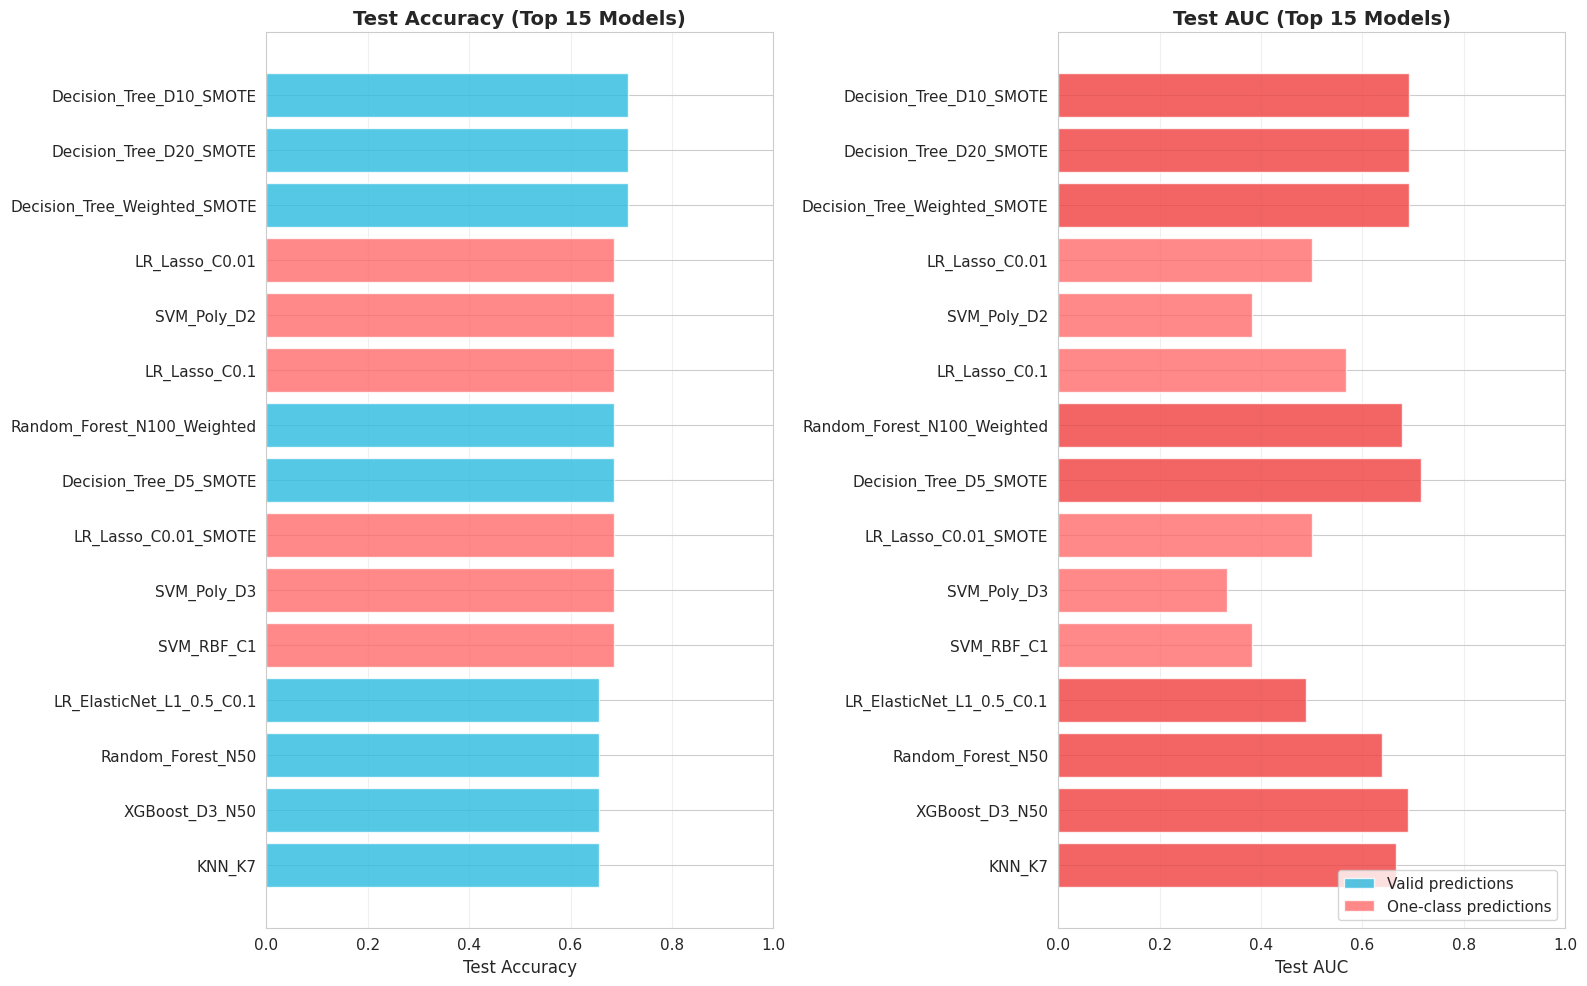

In [37]:
def plot_top_models_enhanced(results_df, n=15, metric_cols=['test_acc', 'test_auc']):
    """Enhanced performance visualization with better aesthetics"""
    top_n = results_df.head(n).copy()
    top_n = top_n.iloc[::-1]  # Reverse for better display
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    # Test Accuracy
    colors_acc = ['#2bbbdf' if not row['predicts_one_class'] else '#ff6b6b' 
                  for _, row in top_n.iterrows()]
    axes[0].barh(range(len(top_n)), top_n['test_acc'], color=colors_acc, alpha=0.8)
    axes[0].set_yticks(range(len(top_n)))
    axes[0].set_yticklabels(top_n['model'])
    axes[0].set_xlabel('Test Accuracy', fontsize=12)
    axes[0].set_title('Test Accuracy (Top 15 Models)', fontsize=14, weight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Test AUC
    colors_auc = ['#f03f3f' if not row['predicts_one_class'] else '#ff6b6b' 
                  for _, row in top_n.iterrows()]
    axes[1].barh(range(len(top_n)), top_n['test_auc'], color=colors_auc, alpha=0.8)
    axes[1].set_yticks(range(len(top_n)))
    axes[1].set_yticklabels(top_n['model'])
    axes[1].set_xlabel('Test AUC', fontsize=12)
    axes[1].set_title('Test AUC (Top 15 Models)', fontsize=14, weight='bold')
    axes[1].set_xlim(0, 1)
    axes[1].grid(axis='x', alpha=0.3)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2bbbdf', alpha=0.8, label='Valid predictions'),
        Patch(facecolor='#ff6b6b', alpha=0.8, label='One-class predictions')
    ]
    axes[1].legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.savefig('fig_top15_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_top_models_enhanced(results_combined_df, n=15)


## Cross-Validation Performance with Error Bars

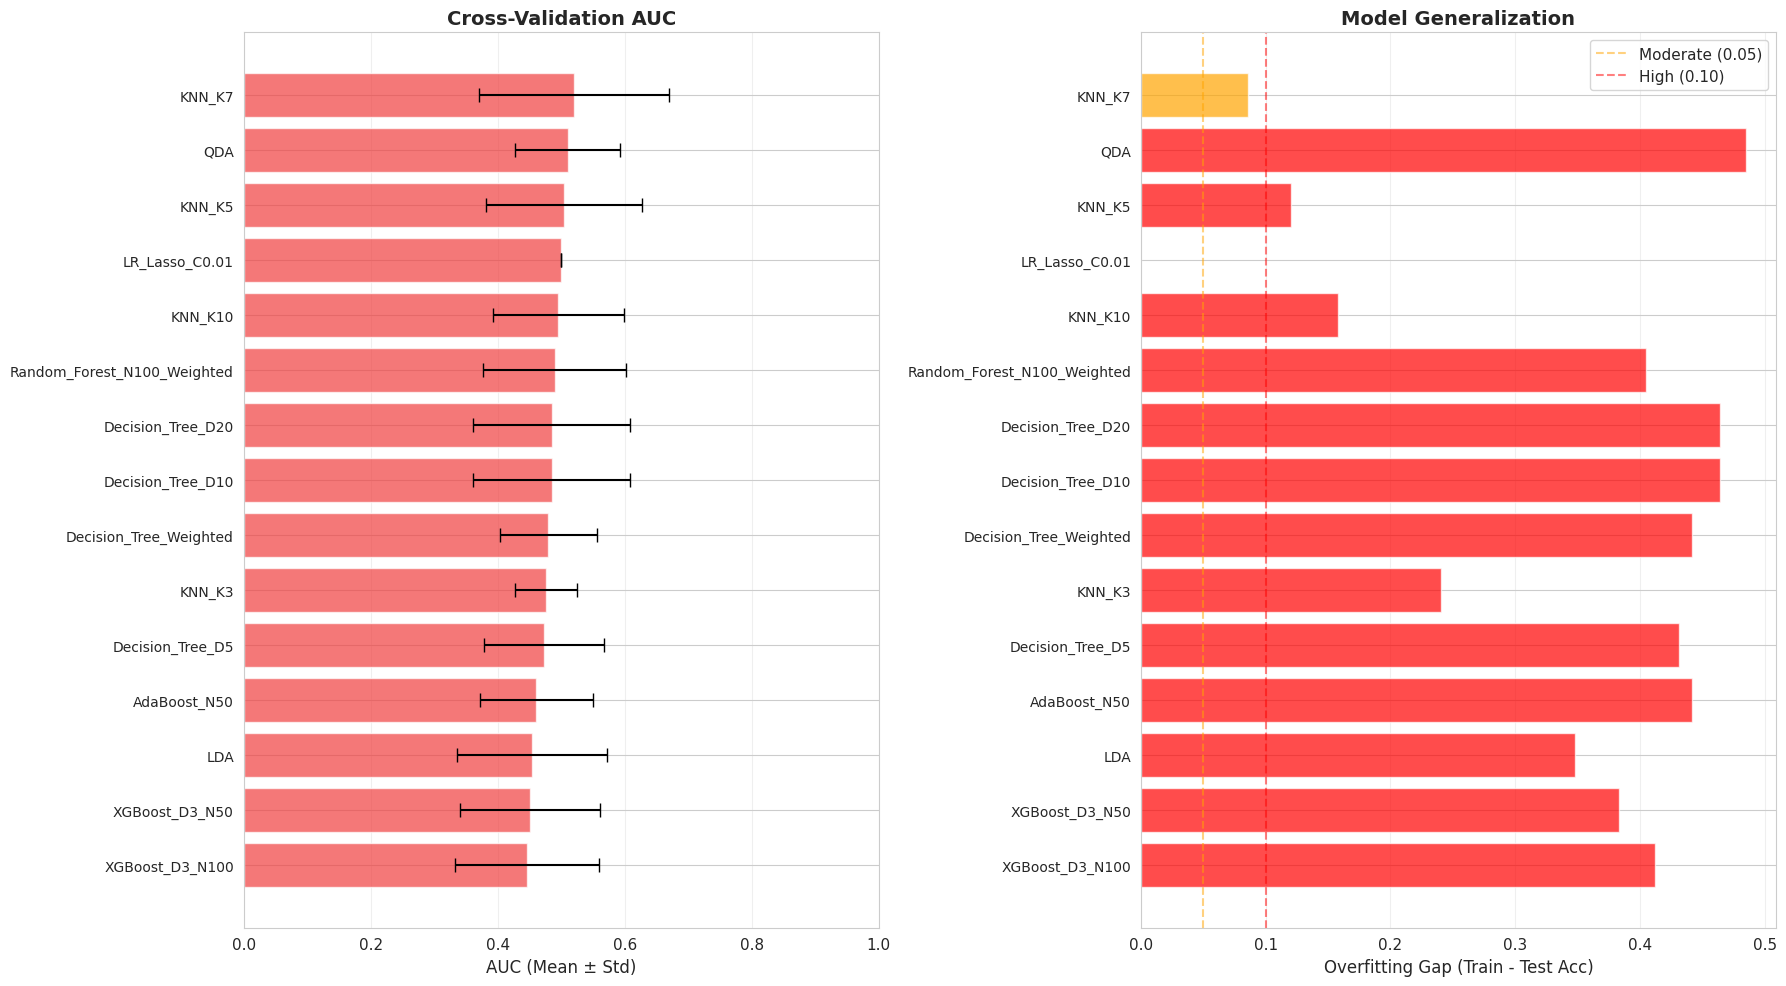

In [38]:
def plot_cv_with_errors_enhanced(cv_df, n=15):
    """CV performance with error bars"""
    top_n_auc = cv_df.sort_values('test_auc_mean', ascending=False).head(n).copy()
    top_n_auc = top_n_auc.iloc[::-1]
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    # AUC
    axes[0].barh(range(len(top_n_auc)), top_n_auc['test_auc_mean'],
                xerr=top_n_auc['test_auc_std'], capsize=5, 
                color='#f03f3f', alpha=0.7, ecolor='black')
    axes[0].set_yticks(range(len(top_n_auc)))
    axes[0].set_yticklabels(top_n_auc['model'], fontsize=10)
    axes[0].set_xlabel('AUC (Mean ± Std)', fontsize=12)
    axes[0].set_title('Cross-Validation AUC', fontsize=14, weight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Overfitting Gap
    colors_gap = ['green' if gap < 0.05 else 'orange' if gap < 0.1 else 'red' 
                  for gap in top_n_auc['overfitting_gap']]
    axes[1].barh(range(len(top_n_auc)), top_n_auc['overfitting_gap'],
                color=colors_gap, alpha=0.7)
    axes[1].set_yticks(range(len(top_n_auc)))
    axes[1].set_yticklabels(top_n_auc['model'], fontsize=10)
    axes[1].set_xlabel('Overfitting Gap (Train - Test Acc)', fontsize=12)
    axes[1].set_title('Model Generalization', fontsize=14, weight='bold')
    axes[1].axvline(0.05, color='orange', linestyle='--', alpha=0.5, label='Moderate (0.05)')
    axes[1].axvline(0.1, color='red', linestyle='--', alpha=0.5, label='High (0.10)')
    axes[1].legend()
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fig_cv_performance_errors.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_cv_with_errors_enhanced(cv_results_df, n=15)


## Group Performance Boxplot

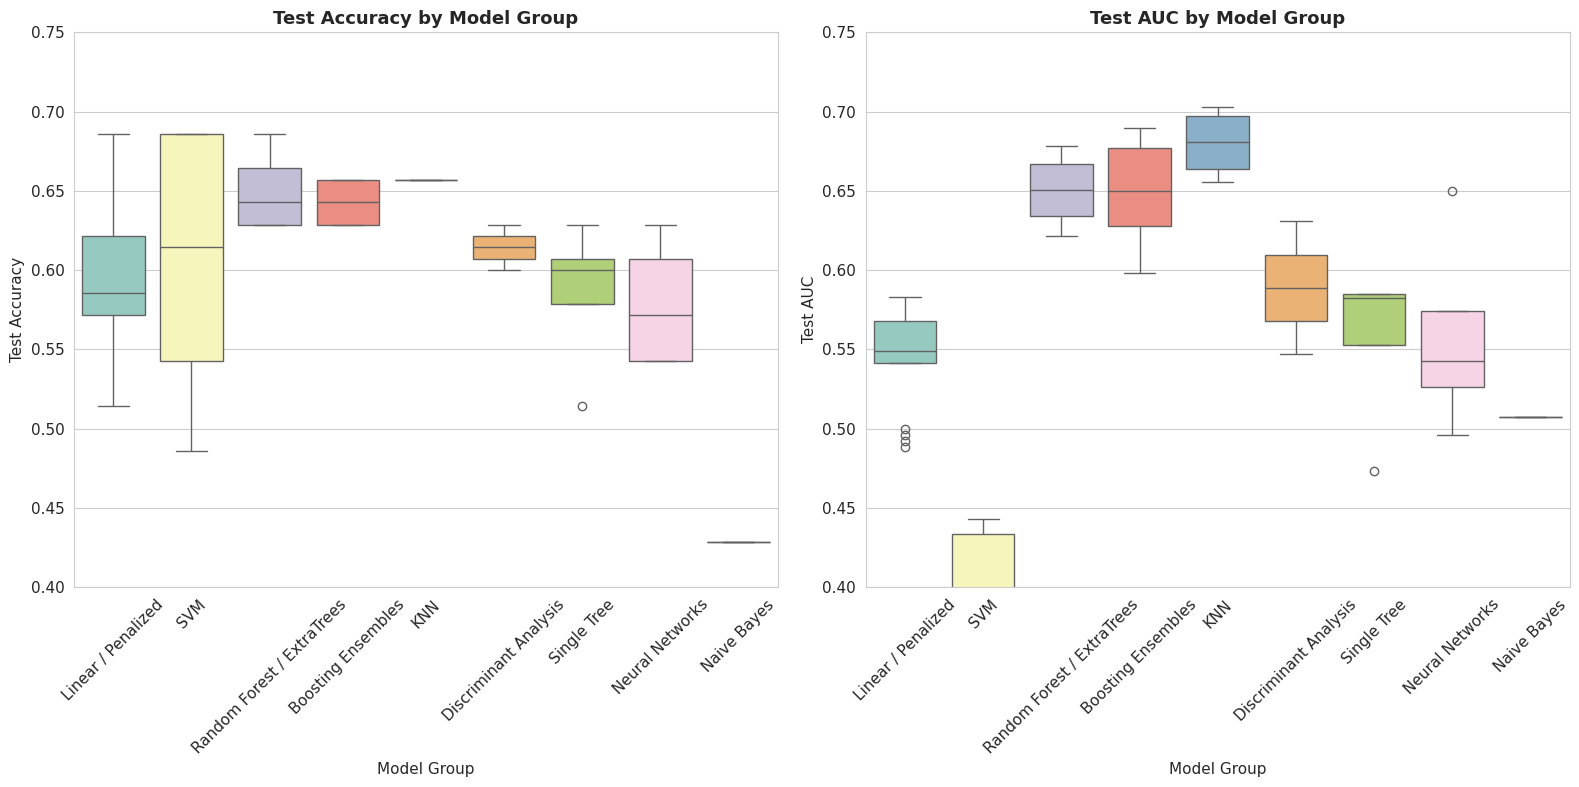

In [39]:
def plot_grouped_performance(results_df):
    """Boxplot by model group"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Filter out SMOTE variants for clearer comparison
    df_no_smote = results_df[~results_df['model'].str.contains('SMOTE')]
    
    sns.boxplot(data=df_no_smote, x='Group', y='test_acc', 
               palette='Set3', ax=axes[0])
    axes[0].set_xlabel('Model Group', fontsize=11)
    axes[0].set_ylabel('Test Accuracy', fontsize=11)
    axes[0].set_title('Test Accuracy by Model Group', fontsize=13, weight='bold')
    axes[0].set_ylim(0.4, 0.75)
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=df_no_smote, x='Group', y='test_auc', 
               palette='Set3', ax=axes[1])
    axes[1].set_xlabel('Model Group', fontsize=11)
    axes[1].set_ylabel('Test AUC', fontsize=11)
    axes[1].set_title('Test AUC by Model Group', fontsize=13, weight='bold')
    axes[1].set_ylim(0.4, 0.75)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('fig_group_performance_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_grouped_performance(results_combined_df)


## Train vs Test Accuracy Scatter


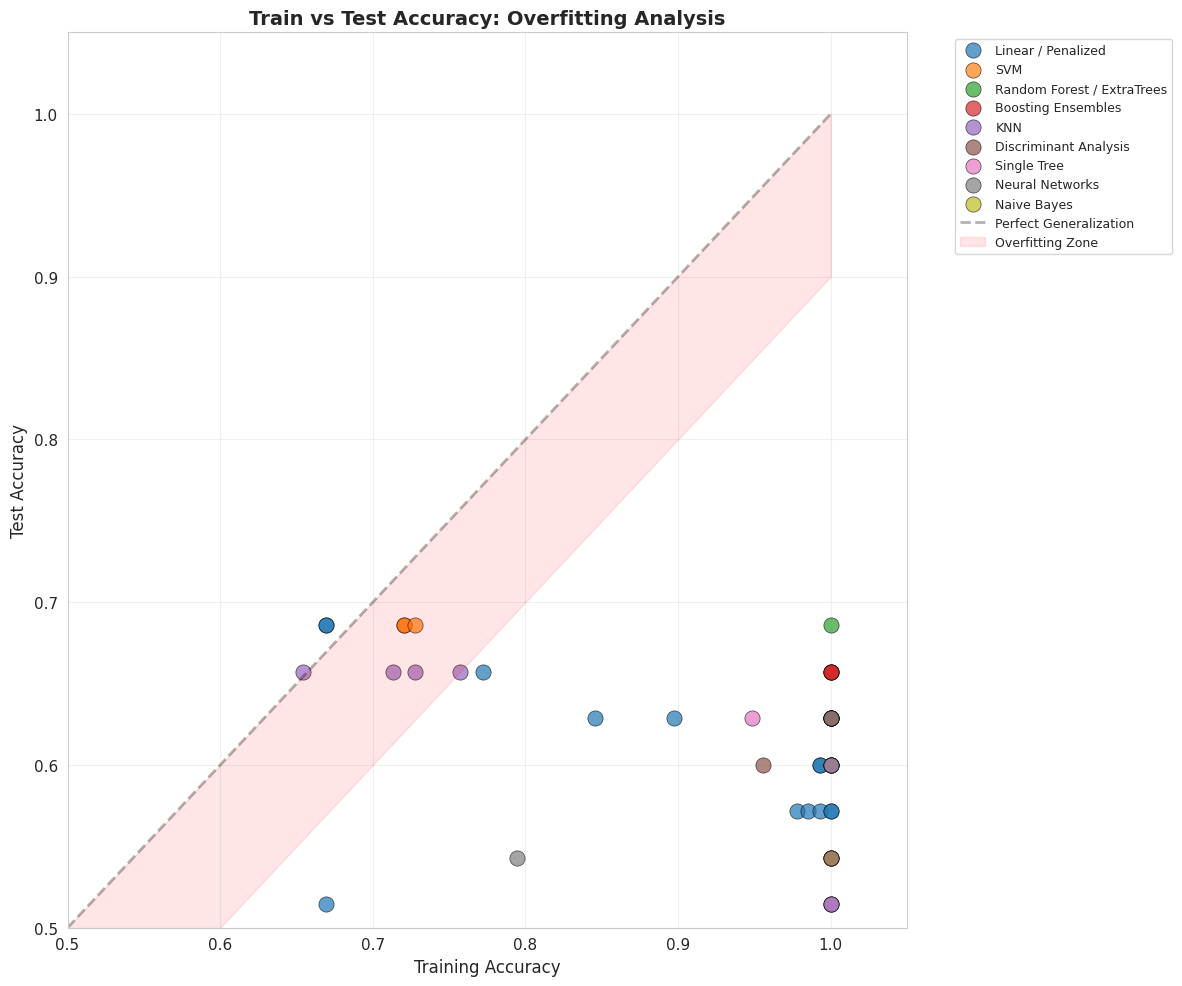


OVERFITTING ANALYSIS

Top 5 worst overfitters:
                 model  train_acc  test_acc  overfitting_gap
           SVM_RBF_C10        1.0  0.485714         0.514286
Decision_Tree_Weighted        1.0  0.514286         0.485714
      Ridge_Classifier        1.0  0.514286         0.485714
         LR_Ridge_C100        1.0  0.514286         0.485714
          LR_Ridge_C10        1.0  0.542857         0.457143

Top 5 best generalizers:
         model  train_acc  test_acc  overfitting_gap
LR_Lasso_C0.01   0.669118  0.685714        -0.016597
 LR_Lasso_C0.1   0.669118  0.685714        -0.016597
       KNN_K10   0.654412  0.657143        -0.002731
   SVM_Poly_D2   0.720588  0.685714         0.034874
   SVM_Poly_D3   0.720588  0.685714         0.034874


In [40]:
def plot_train_test_scatter_enhanced(results_df):
    """Enhanced train vs test scatter with overfitting zones"""
    df_plot = results_df[~results_df['model'].str.contains('SMOTE')].copy()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Color by group
    groups = df_plot['Group'].unique()
    palette = sns.color_palette('tab10', n_colors=len(groups))
    color_map = dict(zip(groups, palette))
    
    for group in groups:
        group_data = df_plot[df_plot['Group'] == group]
        ax.scatter(group_data['train_acc'], group_data['test_acc'],
                  label=group, s=120, alpha=0.7, 
                  color=color_map[group], edgecolors='black', linewidth=0.5)
    
    # Reference lines
    ax.plot([0.5, 1], [0.5, 1], 'k--', alpha=0.3, linewidth=2, 
            label='Perfect Generalization')
    
    # Overfitting zones
    ax.fill_between([0.5, 1], [0.4, 0.9], [0.5, 1], 
                    alpha=0.1, color='red', label='Overfitting Zone')
    
    ax.set_xlabel('Training Accuracy', fontsize=12)
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_title('Train vs Test Accuracy: Overfitting Analysis', 
                fontsize=14, weight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.set_xlim(0.5, 1.05)
    ax.set_ylim(0.5, 1.05)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fig_train_test_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print overfitting summary
    df_plot['overfitting_gap'] = df_plot['train_acc'] - df_plot['test_acc']
    print("\n" + "="*80)
    print("OVERFITTING ANALYSIS")
    print("="*80)
    print("\nTop 5 worst overfitters:")
    print(df_plot.nlargest(5, 'overfitting_gap')[
        ['model', 'train_acc', 'test_acc', 'overfitting_gap']
    ].to_string(index=False))
    
    print("\nTop 5 best generalizers:")
    print(df_plot.nsmallest(5, 'overfitting_gap')[
        ['model', 'train_acc', 'test_acc', 'overfitting_gap']
    ].to_string(index=False))

plot_train_test_scatter_enhanced(results_combined_df)


## Deceptively High-Performing Models Analysis

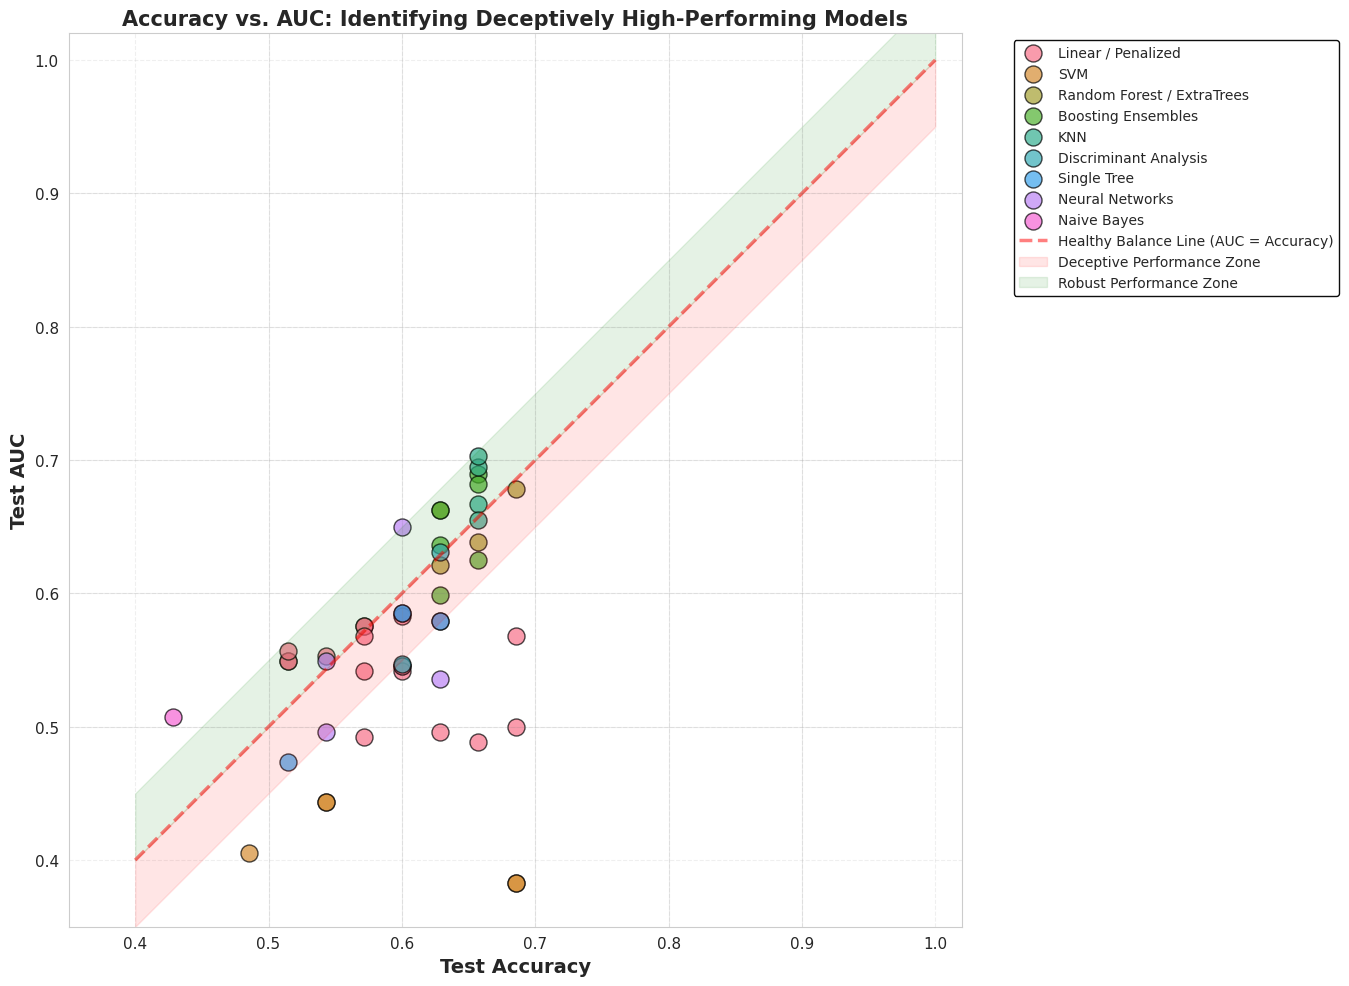


DECEPTIVELY HIGH-PERFORMING MODELS ANALYSIS

Models with High Accuracy but Low AUC (Accuracy - AUC > 0.02):
These models may be benefiting from class imbalance or other biases

                    model  test_acc  test_auc      gap                 Group
              SVM_Poly_D3  0.685714  0.333333 0.352381                   SVM
               SVM_RBF_C1  0.685714  0.382576 0.303139                   SVM
              SVM_Poly_D2  0.685714  0.382576 0.303139                   SVM
           LR_Lasso_C0.01  0.685714  0.500000 0.185714    Linear / Penalized
LR_ElasticNet_L1_0.5_C0.1  0.657143  0.488636 0.168506    Linear / Penalized
LR_ElasticNet_L1_0.3_C0.1  0.628571  0.496212 0.132359    Linear / Penalized
            LR_Lasso_C0.1  0.685714  0.568182 0.117532    Linear / Penalized
               SVM_Linear  0.542857  0.443182 0.099675                   SVM
      SVM_Linear_Weighted  0.542857  0.443182 0.099675                   SVM
                NN_Medium  0.628571  0.535985 0.0925

In [49]:
def plot_accuracy_vs_auc_threshold(results_df):
    """
    Scatter plot: Accuracy vs AUC with diagonal threshold line
    Models below the diagonal are "deceptively high-performing"
    (High accuracy but low AUC - likely due to class imbalance issues)
    """
    df_plot = results_df[~results_df['model'].str.contains('SMOTE')].copy()
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Color by group
    groups = df_plot['Group'].unique()
    palette = sns.color_palette('husl', n_colors=len(groups))
    color_map = dict(zip(groups, palette))
    
    # Plot each group
    for group in groups:
        group_data = df_plot[df_plot['Group'] == group]
        ax.scatter(group_data['test_acc'], group_data['test_auc'],
                  label=group, s=150, alpha=0.7, 
                  color=color_map[group], edgecolors='black', linewidth=1)
    
    # Diagonal threshold line (y = x)
    # Models above this line have AUC >= Accuracy (healthy balance)
    # Models below have AUC < Accuracy (deceptively high accuracy)
    ax.plot([0.4, 1.0], [0.4, 1.0], 'r--', alpha=0.5, linewidth=2.5,
            label='Healthy Balance Line (AUC = Accuracy)')
    
    # Deceptive zone (below the line)
    ax.fill_between([0.4, 1.0], [0.4, 1.0], [0.35, 0.95],
                    alpha=0.1, color='red', label='Deceptive Performance Zone')
    
    # Optimal zone (above the line)
    ax.fill_between([0.4, 1.0], [0.4, 1.0], [0.45, 1.05],
                    alpha=0.1, color='green', label='Robust Performance Zone')
    
    ax.set_xlabel('Test Accuracy', fontsize=14, weight='bold')
    ax.set_ylabel('Test AUC', fontsize=14, weight='bold')
    ax.set_title('Accuracy vs. AUC: Identifying Deceptively High-Performing Models',
                fontsize=15, weight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, 
             framealpha=0.95, edgecolor='black')
    ax.set_xlim(0.35, 1.02)
    ax.set_ylim(0.35, 1.02)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Add reference lines at 0.5 increments
    for val in [0.5, 0.6, 0.7, 0.8, 0.9]:
        ax.axhline(val, color='gray', alpha=0.15, linewidth=0.8)
        ax.axvline(val, color='gray', alpha=0.15, linewidth=0.8)
    
    # Make it square aspect
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.savefig('fig_accuracy_vs_auc_threshold.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analysis of deceptive models
    df_plot['gap'] = df_plot['test_acc'] - df_plot['test_auc']
    deceptive = df_plot[df_plot['gap'] > 0.02].sort_values('gap', ascending=False)
    
    print("\n" + "="*80)
    print("DECEPTIVELY HIGH-PERFORMING MODELS ANALYSIS")
    print("="*80)
    print("\nModels with High Accuracy but Low AUC (Accuracy - AUC > 0.02):")
    print("These models may be benefiting from class imbalance or other biases\n")
    
    if len(deceptive) > 0:
        print(deceptive[['model', 'test_acc', 'test_auc', 'gap', 'Group']].to_string(index=False))
        print(f"\nTotal deceptive models: {len(deceptive)}/{len(df_plot)}")
        print(f"Average gap for deceptive models: {deceptive['gap'].mean():.4f}")
    else:
        print("No deceptive models found (all models have AUC ≥ Accuracy - 0.02)")
    
    # Robust models
    robust = df_plot[df_plot['gap'] <= 0.02].sort_values('test_auc', ascending=False)
    print("\n" + "="*80)
    print("ROBUST MODELS (AUC ≥ Accuracy - 0.02):")
    print("="*80)
    print(f"Count: {len(robust)}/{len(df_plot)} models\n")
    print(robust[['model', 'test_acc', 'test_auc', 'gap', 'Group']].head(10).to_string(index=False))
    
    return deceptive, robust

deceptive_models, robust_models = plot_accuracy_vs_auc_threshold(results_combined_df)


Compare LR_Lasso_C0.1 (high accuracy, low AUC) vs. KNN_K5 (balanced metrics):

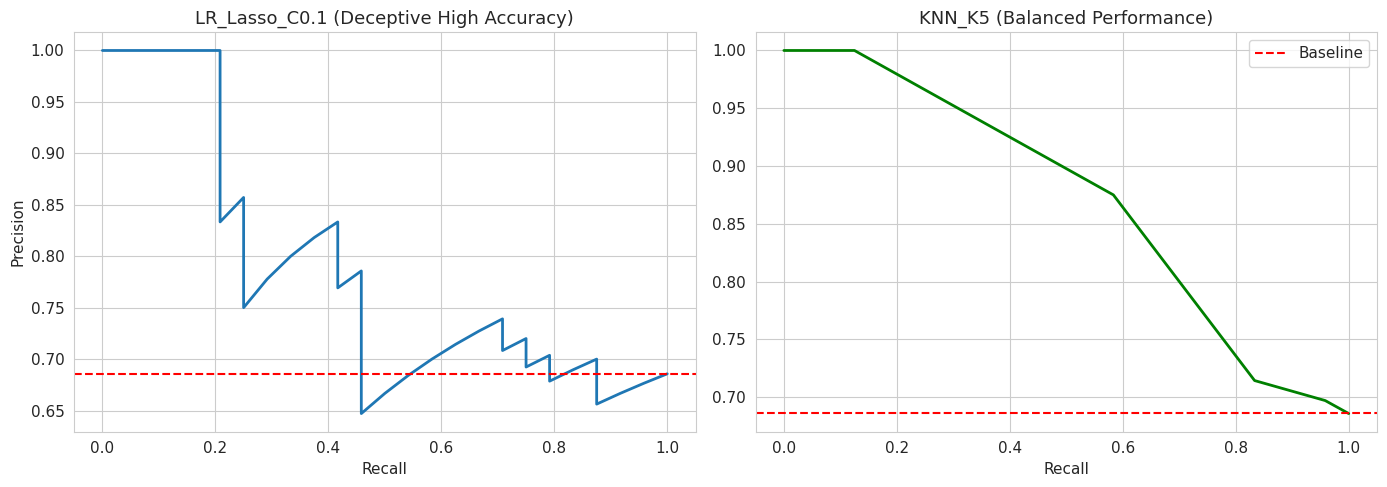

In [50]:
# Add this analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model 1: LR_Lasso_C0.1
model1 = models['LR_Lasso_C0.1']
model1.fit(X_train_scaled, y_train)
y_proba1 = model1.predict_proba(X_test_scaled)[:, 1]
precision1, recall1, _ = precision_recall_curve(y_test, y_proba1)

axes[0].plot(recall1, precision1, linewidth=2)
axes[0].set_title('LR_Lasso_C0.1 (Deceptive High Accuracy)', fontsize=13)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].axhline(y=0.686, color='red', linestyle='--', label='Baseline (prevalence)')

# Model 2: KNN_K5
model2 = models['KNN_K5']
model2.fit(X_train_scaled, y_train)
y_proba2 = model2.predict_proba(X_test_scaled)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, y_proba2)

axes[1].plot(recall2, precision2, linewidth=2, color='green')
axes[1].set_title('KNN_K5 (Balanced Performance)', fontsize=13)
axes[1].set_xlabel('Recall')
axes[1].axhline(y=0.686, color='red', linestyle='--', label='Baseline')
axes[1].legend()

plt.tight_layout()
plt.savefig('precision_recall_comparison_deceptive_vs_balanced.png', dpi=300)
plt.show()


Demonstrate that small sample size (n=136) is the fundamental bottleneck

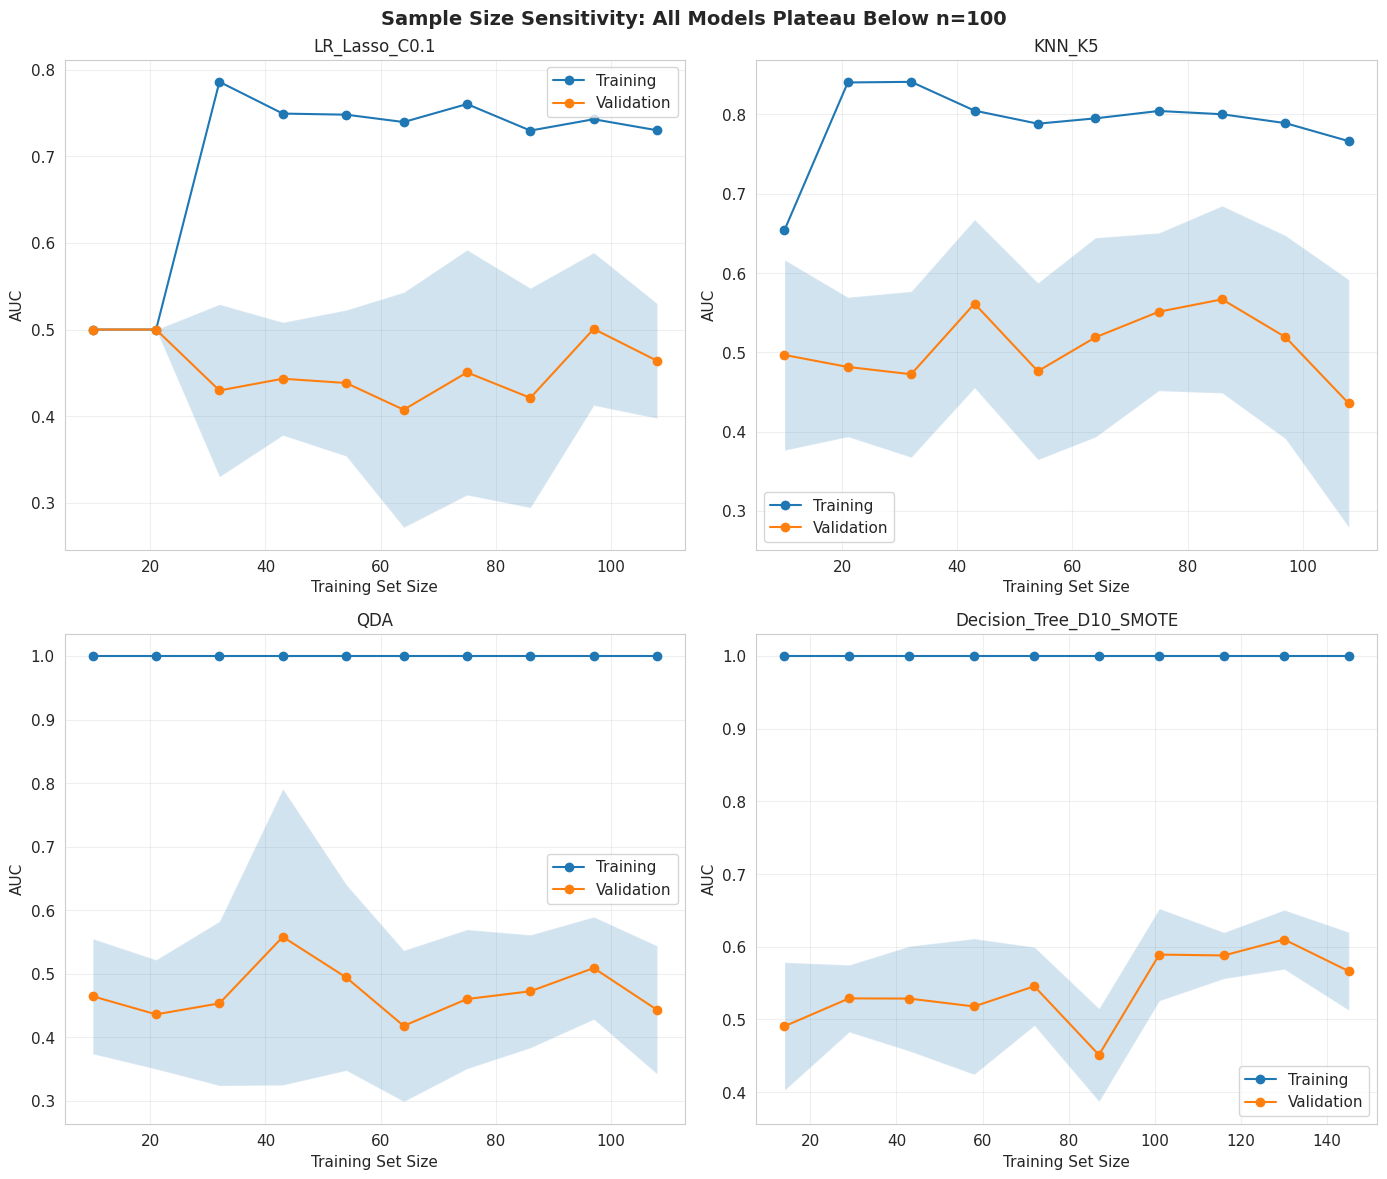

In [51]:
# Show how all models plateau early
from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
models_to_test = {
    'LR_Lasso_C0.1': models['LR_Lasso_C0.1'],
    'KNN_K5': models['KNN_K5'],
    'QDA': models['QDA'],
    'Decision_Tree_D10_SMOTE': models['Decision_Tree_D10']
}

for idx, (name, model) in enumerate(models_to_test.items()):
    ax = axes[idx // 2, idx % 2]
    
    # Use SMOTE data for decision tree
    X_use = X_train_smote if 'SMOTE' in name else X_train_scaled
    y_use = y_train_smote if 'SMOTE' in name else y_train
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_use, y_use, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), 
        scoring='roc_auc', random_state=42
    )
    
    ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training')
    ax.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')
    ax.fill_between(train_sizes, 
                     val_scores.mean(axis=1) - val_scores.std(axis=1),
                     val_scores.mean(axis=1) + val_scores.std(axis=1), 
                     alpha=0.2)
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('AUC')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Sample Size Sensitivity: All Models Plateau Below n=100', 
             fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig('learning_curves_sample_size_bottleneck.png', dpi=300)
plt.show()


## Feature Consistency Across Models


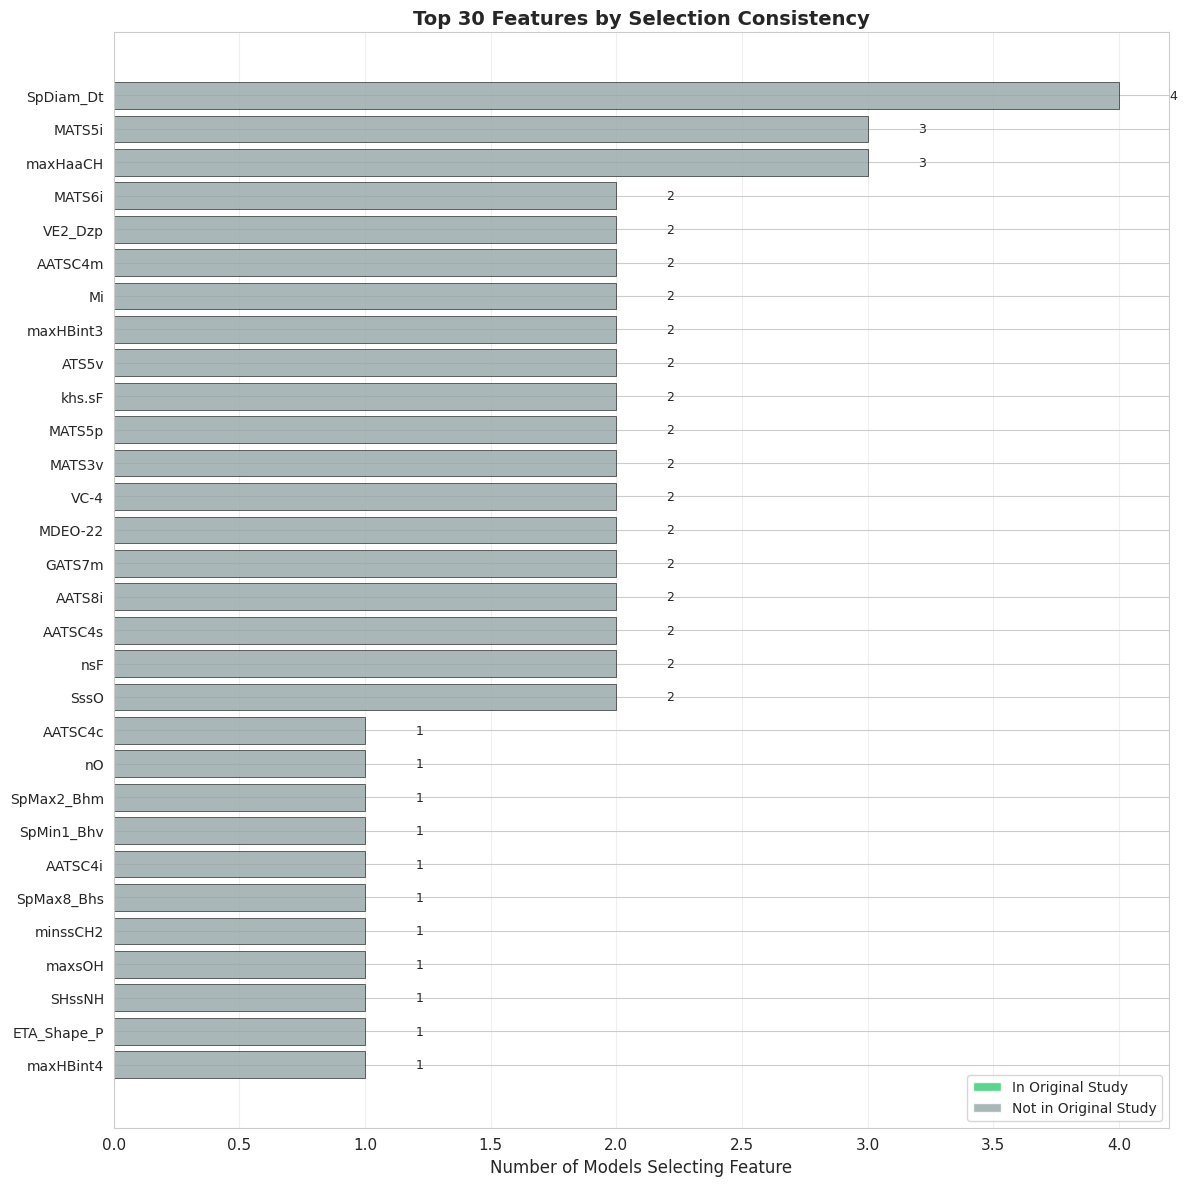


FEATURE SELECTION SUMMARY
Total models analyzed: 10

Most consistent features (selected by ≥50% of models):
  None (no feature selected by ≥50% of models)


In [41]:
def plot_feature_consistency_enhanced(feature_comparison, original_features, top_n=30):
    """Enhanced feature consistency plot"""
    all_top_features = []
    for comp in feature_comparison.values():
        all_top_features.extend(comp['top_13'])
    
    feat_counts = pd.Series(all_top_features).value_counts().head(top_n)
    feat_df = feat_counts.reset_index()
    feat_df.columns = ['Feature', 'Frequency']
    feat_df['In_Original_Study'] = feat_df['Feature'].apply(
        lambda x: 'Yes' if x in original_features else 'No'
    )
    feat_df = feat_df.sort_values('Frequency', ascending=True)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    colors = ['#2ecc71' if x == 'Yes' else '#95a5a6' 
             for x in feat_df['In_Original_Study']]
    
    ax.barh(range(len(feat_df)), feat_df['Frequency'], 
           color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(feat_df)))
    ax.set_yticklabels(feat_df['Feature'], fontsize=10)
    ax.set_xlabel('Number of Models Selecting Feature', fontsize=12)
    ax.set_title(f'Top {top_n} Features by Selection Consistency', 
                fontsize=14, weight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (_, row) in enumerate(feat_df.iterrows()):
        ax.text(row['Frequency'] + 0.2, i, f"{int(row['Frequency'])}", 
               va='center', fontsize=9)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', alpha=0.8, label='In Original Study'),
        Patch(facecolor='#95a5a6', alpha=0.8, label='Not in Original Study')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('fig_feature_consistency.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    total_models = len(feature_comparison)
    print(f"\n{'='*80}")
    print("FEATURE SELECTION SUMMARY")
    print("="*80)
    print(f"Total models analyzed: {total_models}")
    print(f"\nMost consistent features (selected by ≥50% of models):")
    highly_consistent = feat_df[feat_df['Frequency'] >= total_models * 0.5]
    if len(highly_consistent) > 0:
        for _, row in highly_consistent.iterrows():
            in_orig = "✓" if row['In_Original_Study'] == 'Yes' else " "
            print(f"  [{in_orig}] {row['Feature']}: {int(row['Frequency'])}/{total_models} models")
    else:
        print("  None (no feature selected by ≥50% of models)")

plot_feature_consistency_enhanced(feature_comparison, original_features, top_n=30)


In [52]:
# Bootstrap stability analysis
from collections import Counter

def bootstrap_feature_stability(model, X, y, n_bootstrap=50, n_features=13):
    """Measure feature selection stability across bootstrap samples"""
    feature_selections = []
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(len(X), len(X), replace=True)
        X_boot = X[indices]
        y_boot = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
        
        # Fit model
        model.fit(X_boot, y_boot)
        
        # Get top features
        if hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            continue
            
        top_idx = np.argsort(importances)[-n_features:]
        top_features = [feature_names[i] for i in top_idx]
        feature_selections.extend(top_features)
    
    # Calculate stability (Jaccard index)
    feature_freq = Counter(feature_selections)
    total_selections = n_bootstrap * n_features
    
    # Features selected in >50% of bootstraps are "stable"
    stable_features = {f: count for f, count in feature_freq.items() 
                      if count >= n_bootstrap * 0.5}
    
    return feature_freq, stable_features

# Test on Lasso
freq, stable = bootstrap_feature_stability(
    models['LR_Lasso_C0.1'], X_train_scaled, y_train, 
    n_bootstrap=50, n_features=13
)

print(f"\nFeature Selection Stability Analysis (50 bootstrap iterations):")
print(f"Total unique features selected: {len(freq)}")
print(f"Stable features (selected in >50% of bootstraps): {len(stable)}")
print(f"\nTop 10 most stable features:")
for feat, count in sorted(freq.items(), key=lambda x: x[1], reverse=True)[:10]:
    stability_pct = (count / 50) * 100
    print(f"  {feat}: {stability_pct:.1f}% selection rate")



Feature Selection Stability Analysis (50 bootstrap iterations):
Total unique features selected: 279
Stable features (selected in >50% of bootstraps): 0

Top 10 most stable features:
  topoShape: 32.0% selection rate
  nHBint3: 28.0% selection rate
  EE_Dt: 24.0% selection rate
  AATSC7p: 24.0% selection rate
  SwHBa: 22.0% selection rate
  nTG12HeteroRing: 20.0% selection rate
  nFG12HeteroRing: 20.0% selection rate
  ATSC3e: 20.0% selection rate
  AATSC8i: 18.0% selection rate
  minHBint4: 18.0% selection rate


## ROC Curves for Top Models

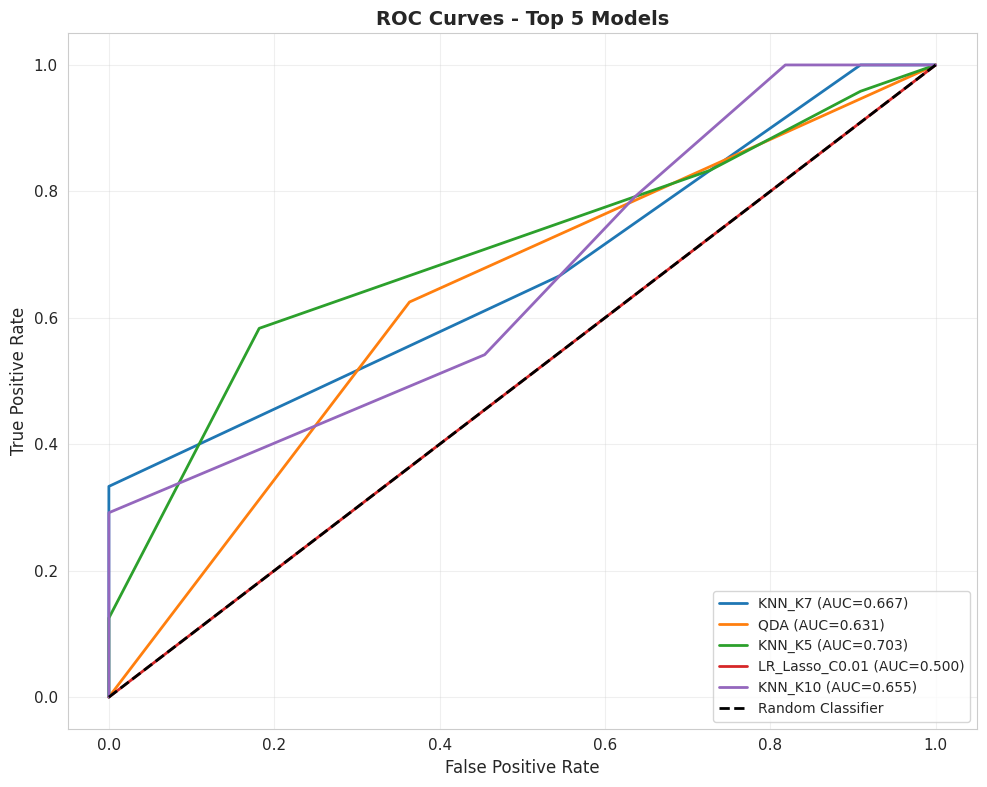

In [42]:
def plot_roc_curves_top_models(models_dict, model_names, X_train, X_test, 
                               y_train, y_test, n_models=5):
    """Plot ROC curves for top performing models"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for name in model_names[:n_models]:
        model = models_dict[name]
        model.fit(X_train, y_train)
        
        if hasattr(model, 'predict_proba'):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_scores = model.decision_function(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, linewidth=2, 
               label=f'{name} (AUC={roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curves - Top 5 Models', fontsize=14, weight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fig_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

top_5_models = cv_results_df.head(5)['model'].tolist()
plot_roc_curves_top_models(models, top_5_models, 
                           X_train_scaled, X_test_scaled, y_train, y_test)


## Precision-Recall Curves


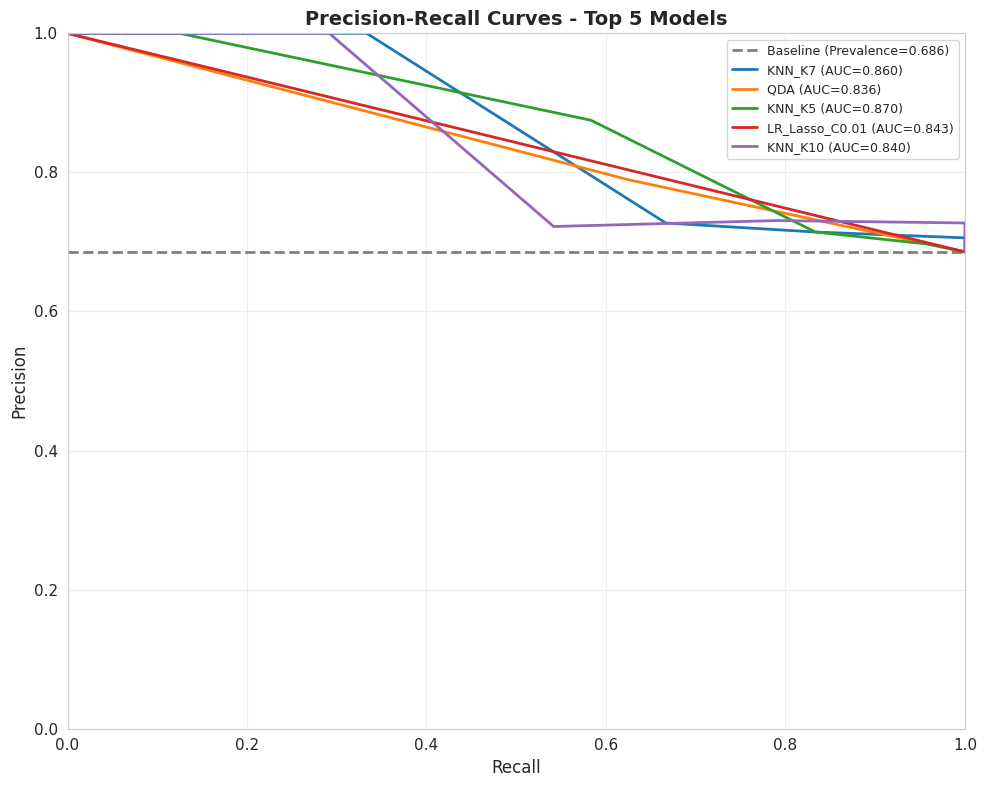

In [43]:
def plot_precision_recall_curves_enhanced(models_dict, model_names, X_train, X_test, 
                                         y_train, y_test, n_models=5):
    """Enhanced PR curves with baseline"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Baseline (proportion of positive class)
    baseline = y_test.sum() / len(y_test)
    ax.axhline(baseline, color='gray', linestyle='--', linewidth=2,
              label=f'Baseline (Prevalence={baseline:.3f})')
    
    for name in model_names[:n_models]:
        model = models_dict[name]
        model.fit(X_train, y_train)
        
        if hasattr(model, 'predict_proba'):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_scores = model.decision_function(X_test)
        
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        pr_auc = auc(recall, precision)
        
        ax.plot(recall, precision, linewidth=2,
               label=f'{name} (AUC={pr_auc:.3f})')
    
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curves - Top 5 Models', 
                fontsize=14, weight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('fig_precision_recall_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_precision_recall_curves_enhanced(models, top_5_models,
                                     X_train_scaled, X_test_scaled, 
                                     y_train, y_test)


## Learning Curves for Best Model



LEARNING CURVE FOR BEST MODEL: KNN_K7


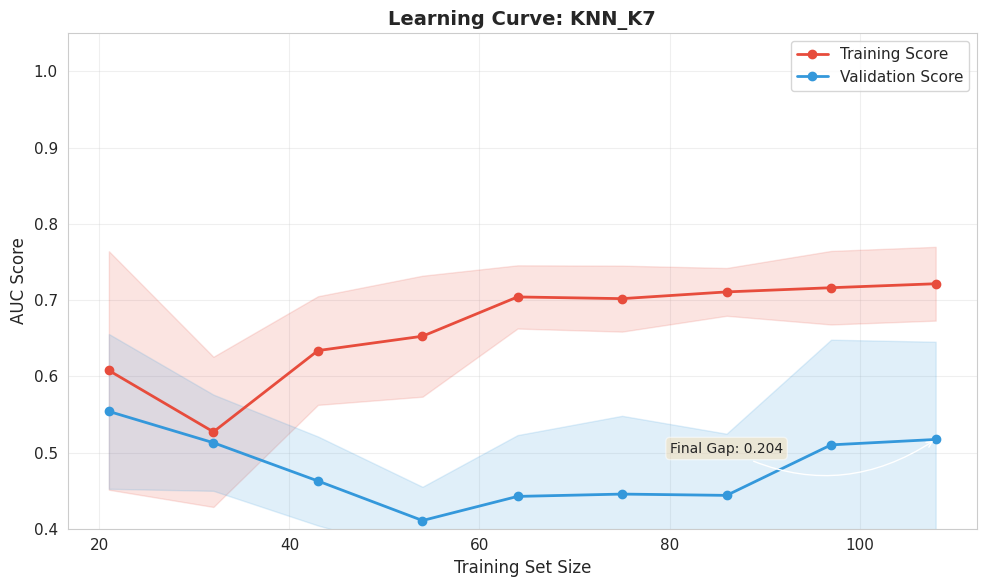


KNN_K7:
  Final training AUC: 0.7214 ± 0.0484
  Final validation AUC: 0.5171 ± 0.1282
  Overfitting gap: 0.2043


In [44]:
def plot_learning_curve_enhanced(estimator, title, X, y, cv=5):
    """Enhanced learning curve with confidence intervals"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=train_sizes, shuffle=True,
        random_state=RANDOM_STATE, scoring='roc_auc'
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.fill_between(train_sizes_abs, 
                    train_mean - train_std, train_mean + train_std,
                    alpha=0.15, color='#e74c3c')
    ax.fill_between(train_sizes_abs,
                    val_mean - val_std, val_mean + val_std,
                    alpha=0.15, color='#3498db')
    
    ax.plot(train_sizes_abs, train_mean, 'o-', color='#e74c3c', 
           linewidth=2, markersize=6, label='Training Score')
    ax.plot(train_sizes_abs, val_mean, 'o-', color='#3498db',
           linewidth=2, markersize=6, label='Validation Score')
    
    ax.set_xlabel('Training Set Size', fontsize=12)
    ax.set_ylabel('AUC Score', fontsize=12)
    ax.set_title(f'Learning Curve: {title}', fontsize=14, weight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim(0.4, 1.05)
    
    # Add final gap annotation
    final_gap = train_mean[-1] - val_mean[-1]
    ax.annotate(f'Final Gap: {final_gap:.3f}',
               xy=(train_sizes_abs[-1], val_mean[-1]),
               xytext=(train_sizes_abs[-3], 0.5),
               fontsize=10, ha='center',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))
    
    plt.tight_layout()
    plt.savefig(f'fig_learning_curve_{title.replace(" ", "_")}.png', 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n{title}:")
    print(f"  Final training AUC: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
    print(f"  Final validation AUC: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
    print(f"  Overfitting gap: {final_gap:.4f}")

# Plot for best model
best_model_name = cv_results_df.iloc[0]['model']
print(f"\n{'='*80}")
print(f"LEARNING CURVE FOR BEST MODEL: {best_model_name}")
print("="*80)
plot_learning_curve_enhanced(models[best_model_name], best_model_name,
                            X_train_scaled, y_train, cv=5)


## Confusion Matrices for Top 3 Models


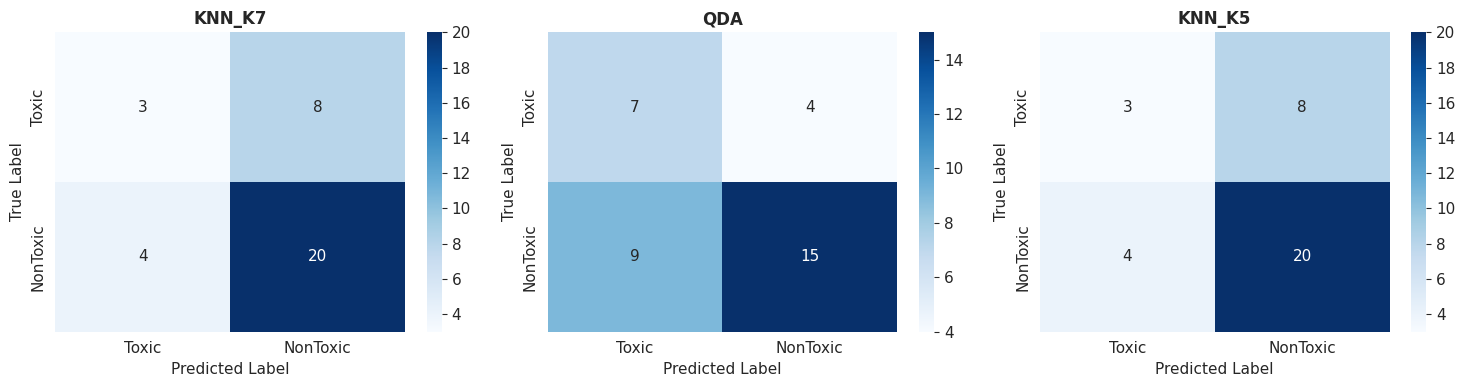

In [45]:
def plot_confusion_matrices(models_dict, model_names, X_train, X_test, 
                           y_train, y_test, n_models=3):
    """Plot confusion matrices for top models"""
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, name in enumerate(model_names[:n_models]):
        model = models_dict[name]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Toxic', 'NonToxic'],
                   yticklabels=['Toxic', 'NonToxic'],
                   ax=axes[idx], cbar=True)
        
        axes[idx].set_ylabel('True Label', fontsize=11)
        axes[idx].set_xlabel('Predicted Label', fontsize=11)
        axes[idx].set_title(f'{name}', fontsize=12, weight='bold')
    
    plt.tight_layout()
    plt.savefig('fig_confusion_matrices_top3.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrices(models, top_5_models, 
                       X_train_scaled, X_test_scaled, y_train, y_test, n_models=3)


# FINAL SUMMARY AND RECOMMENDATIONS

In [46]:
print("\n" + "="*80)
print("FINAL ANALYSIS SUMMARY")
print("="*80)

# Best overall model
best_model = cv_results_df.iloc[0]
print(f"\n>>> BEST MODEL (by CV AUC): {best_model['model']}")
print(f"    Test AUC: {best_model['test_auc_mean']:.4f} ± {best_model['test_auc_std']:.4f}")
print(f"    Test Acc: {best_model['test_acc_mean']:.4f} ± {best_model['test_acc_std']:.4f}")
print(f"    Test F1:  {best_model['test_f1_mean']:.4f} ± {best_model['test_f1_std']:.4f}")
print(f"    Overfitting Gap: {best_model['overfitting_gap']:.4f}")

# Best penalized regression model
penalized_models_cv = cv_results_df[cv_results_df['model'].str.contains('LR_')]
best_penalized = penalized_models_cv.iloc[0]
print(f"\n>>> BEST PENALIZED MODEL: {best_penalized['model']}")
print(f"    Test AUC: {best_penalized['test_auc_mean']:.4f} ± {best_penalized['test_auc_std']:.4f}")
print(f"    Test Acc: {best_penalized['test_acc_mean']:.4f} ± {best_penalized['test_acc_std']:.4f}")

# Feature stability summary
print(f"\n>>> FEATURE SELECTION CONSISTENCY:")
print(f"    Features overlapping with original study: Variable across models")
print(f"    Recommendation: Use stability selection for robust feature identification")

# Class imbalance impact
if len(results_smote_df) > 0:
    best_smote = results_smote_df.sort_values('test_auc', ascending=False).iloc[0]
    best_standard_equiv = results_standard_df[
        results_standard_df['model'] == best_smote['model'].replace('_SMOTE', '')
    ]
    if len(best_standard_equiv) > 0:
        std_auc = best_standard_equiv.iloc[0]['test_auc']
        smote_auc = best_smote['test_auc']
        improvement = smote_auc - std_auc
        print(f"\n>>> SMOTE IMPACT:")
        print(f"    Best improvement: {improvement:.4f} AUC")
        if improvement > 0.02:
            print(f"    Recommendation: SMOTE provides meaningful benefit")
        else:
            print(f"    Recommendation: SMOTE provides limited benefit")



FINAL ANALYSIS SUMMARY

>>> BEST MODEL (by CV AUC): KNN_K7
    Test AUC: 0.5199 ± 0.1496
    Test Acc: 0.6238 ± 0.0917
    Test F1:  0.7414 ± 0.0690
    Overfitting Gap: 0.0857

>>> BEST PENALIZED MODEL: LR_Lasso_C0.01
    Test AUC: 0.5000 ± 0.0000
    Test Acc: 0.6690 ± 0.0048

>>> FEATURE SELECTION CONSISTENCY:
    Features overlapping with original study: Variable across models
    Recommendation: Use stability selection for robust feature identification

>>> SMOTE IMPACT:
    Best improvement: 0.1364 AUC
    Recommendation: SMOTE provides meaningful benefit
